In [1]:
## Loading all the libraries
import pandas as pd
import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt   
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from sklearn.ensemble import IsolationForest
from scipy.cluster import hierarchy

In [2]:
## Loading data files
df = pd.read_csv("dengue_features_train.csv")
labels = pd.read_csv("dengue_labels_train.csv")

# Merging the labels with the features
df = df.merge(labels, on=['city', 'year', 'weekofyear'])

## 1. Summary statistics of all numerical columns

In [3]:
## 1. Summary statistics of all numerical columns
summary = df.describe()
print(summary)

              year   weekofyear      ndvi_ne      ndvi_nw      ndvi_se  \
count  1456.000000  1456.000000  1262.000000  1404.000000  1434.000000   
mean   2001.031593    26.503434     0.142294     0.130553     0.203783   
std       5.408314    15.019437     0.140531     0.119999     0.073860   
min    1990.000000     1.000000    -0.406250    -0.456100    -0.015533   
25%    1997.000000    13.750000     0.044950     0.049217     0.155087   
50%    2002.000000    26.500000     0.128817     0.121429     0.196050   
75%    2005.000000    39.250000     0.248483     0.216600     0.248846   
max    2010.000000    53.000000     0.508357     0.454429     0.538314   

           ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  1434.000000           1443.000000            1446.000000   
mean      0.202305             45.760388             298.701852   
std       0.083903             43.715537               1.362420   
min      -0.063457              0.000000             294.635714  

## 2. Plots of total cases

### a. Distribution

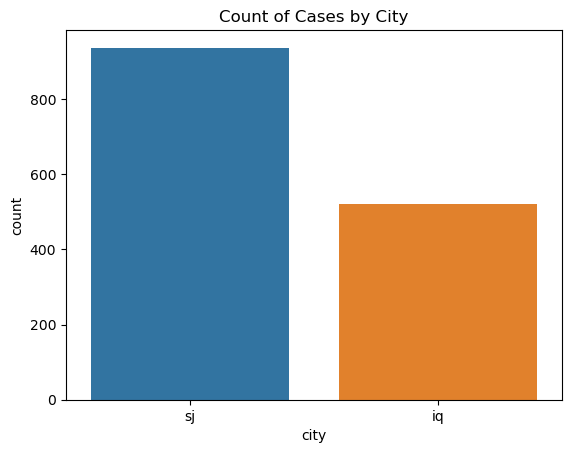

In [4]:
## 2. Plots of total cases
# a. Distribution
sns.countplot(x='city', data=df)
plt.title('Count of Cases by City')
plt.show()

### b. Over time plot

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/2426580642.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='week_start_date', y='total_cases', hue='city', marker='o', ci=None)


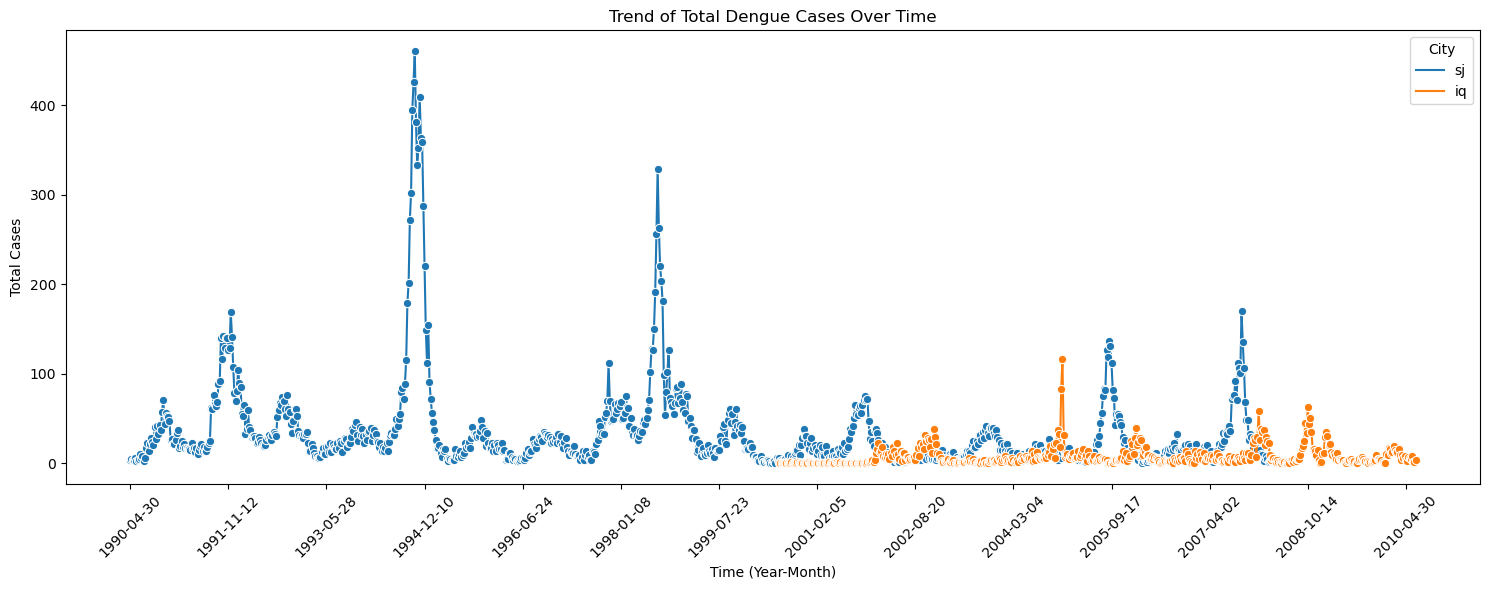

In [5]:
# b. Over time plot
# Improving the trend visualization by cleaning up the x-axis labels
plt.figure(figsize=(15, 6))

# Creating a lineplot with markers and fewer x-axis labels for better readability
sns.lineplot(data=df, x='week_start_date', y='total_cases', hue='city', marker='o', ci=None)

# Formatting the x-axis labels to show the year and month, and rotating them for better visibility
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=15))  # Limiting the number of x-axis labels

plt.title('Trend of Total Dengue Cases Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Total Cases')
plt.legend(title='City')
plt.tight_layout()
plt.show()

### c. Box plot

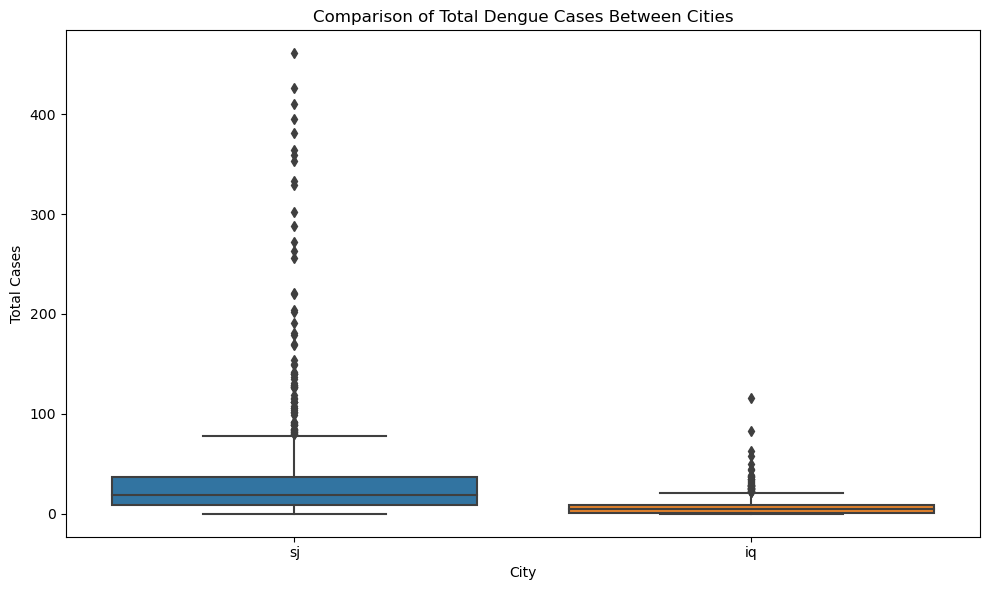

In [6]:
# c. Box plot 
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='city', y='total_cases')
plt.title('Comparison of Total Dengue Cases Between Cities')
plt.xlabel('City')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.show()

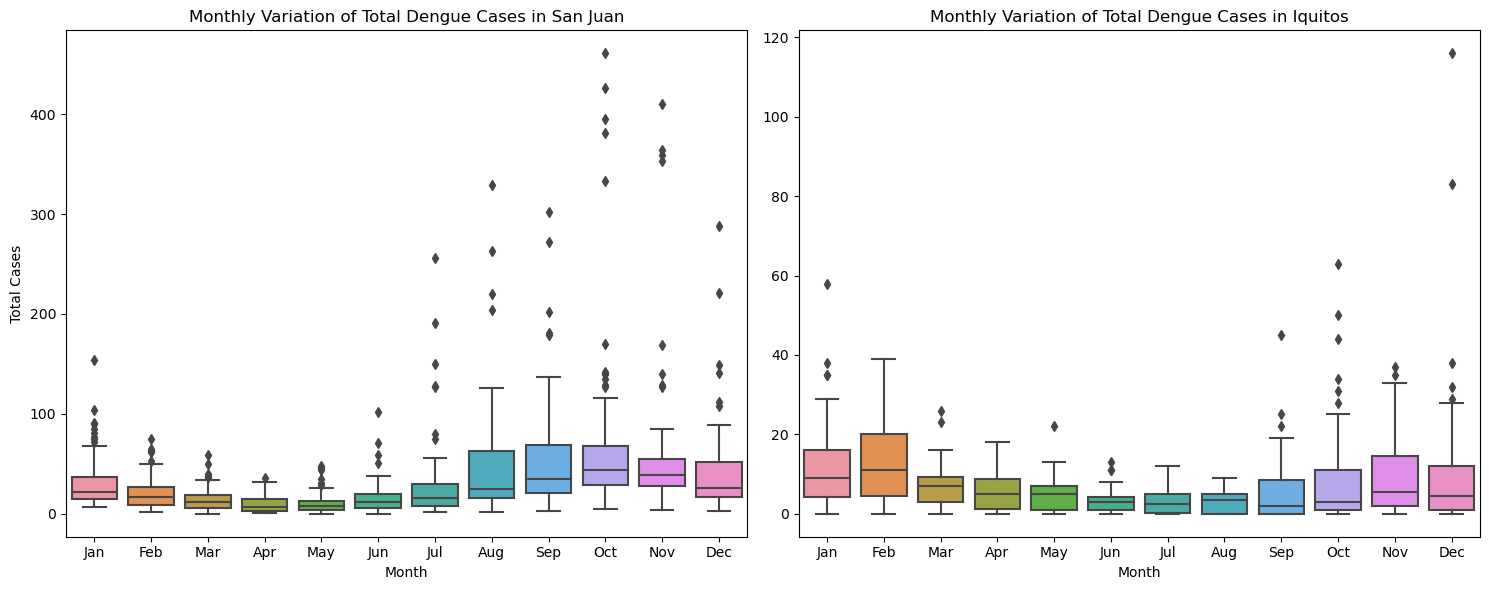

In [7]:
# Box plot：Seasonality Visualization 
# Ensuring the 'week_start_date' column is in datetime format
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Extracting the month names again and creating the seasonality visualization
df['month'] = df['week_start_date'].dt.month_name().str.slice(stop=3)

cities = ['sj', 'iq']
titles = ['San Juan', 'Iquitos']
# Recreating the improved seasonality visualization with the corrected 'month' column
plt.figure(figsize=(15, 6))
for i, city in enumerate(cities, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df[df['city'] == city], 
                x='month', y='total_cases', 
                order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title(f'Monthly Variation of Total Dengue Cases in {titles[i-1]}')
    plt.xlabel('Month')
    plt.ylabel('Total Cases' if i == 1 else '')
    plt.tight_layout()

plt.show()

### d. Stationarity check

/Users/zy/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


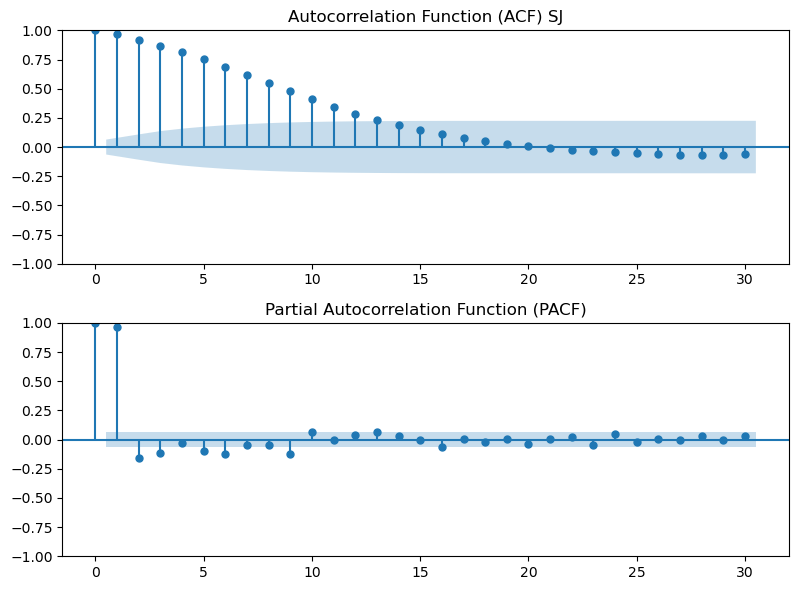

In [8]:
# d. Stationarity check: "sj" city
sj_data = df[df['city'] == 'sj']['total_cases']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# ACF plot
sm.graphics.tsa.plot_acf(sj_data, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) SJ')

# PACF plot
sm.graphics.tsa.plot_pacf(sj_data, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

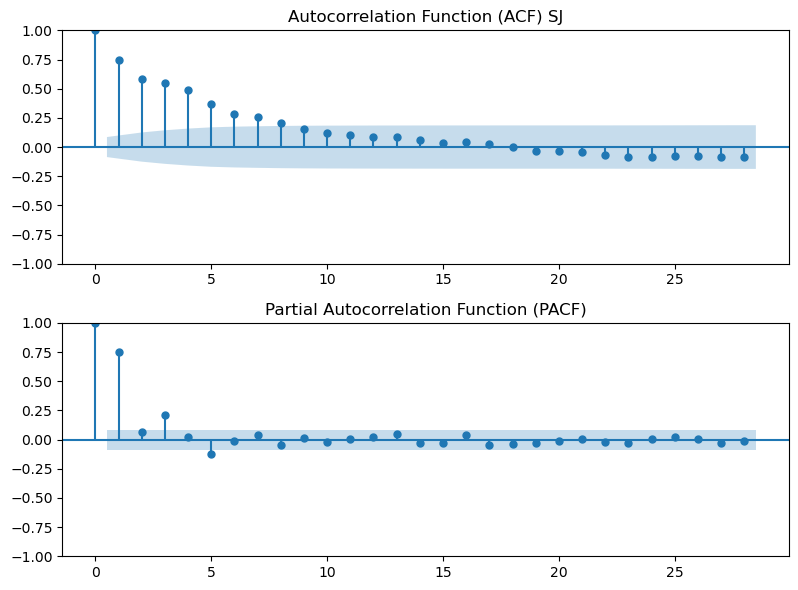

In [9]:
# Stationarity check: "iq" city
iq_data = df[df['city'] == 'iq']['total_cases']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# ACF plot
sm.graphics.tsa.plot_acf(iq_data, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) SJ')

# PACF plot
sm.graphics.tsa.plot_pacf(iq_data, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### e. Plots with lag

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/196794118.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/196794118.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/196794118.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
/var/fo

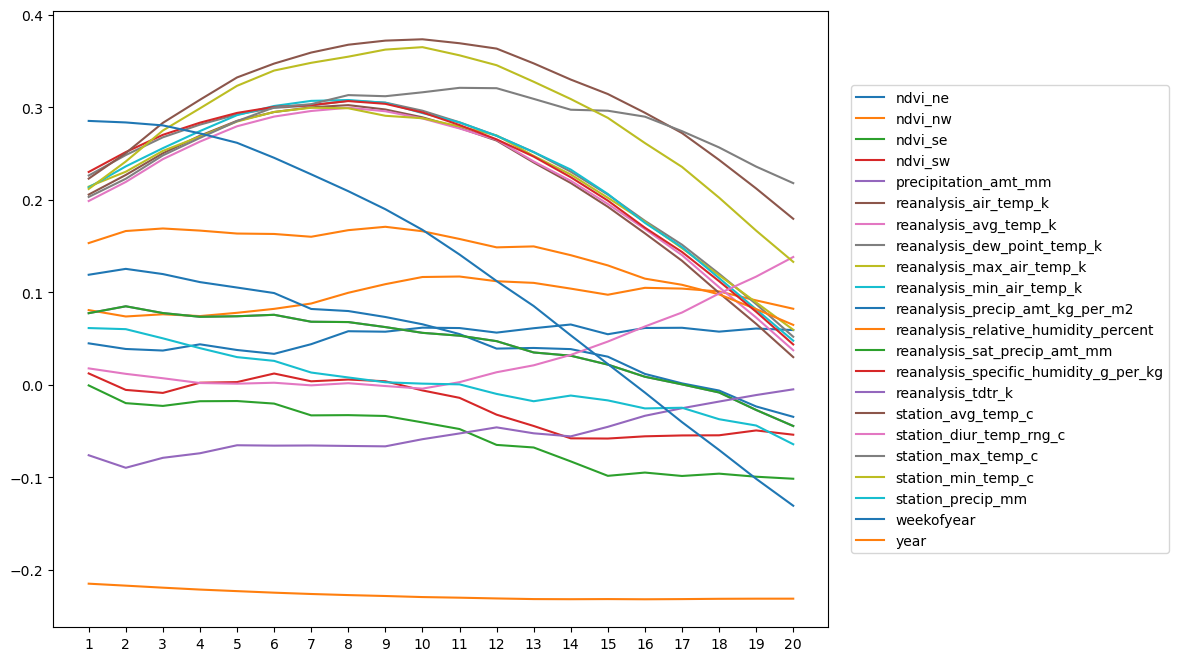

In [10]:
# e. Plots with lag: "sj" city
def corr_heatmap_total_cases(df):
    correlation_matrix = df.corr()
    return correlation_matrix['total_cases'].drop('total_cases') .sort_values(ascending=False)

sj_lag = {}
iq_lag = {}
for i in range(1, 21):
    # Create lagged versions of the DataFrame
    df_lag = pd.concat([df.drop('total_cases', axis=1).shift(i), df['total_cases']], axis=1)
    
    # Filter data for 'sj' and 'iq' cities
    sj_data = df_lag[df_lag['city'] == 'sj']
    iq_data = df_lag[df_lag['city'] == 'iq']

    # Calculate correlation heatmaps for 'sj' and 'iq'
    sj_lag[i] = corr_heatmap_total_cases(sj_data)
    iq_lag[i] = corr_heatmap_total_cases(iq_data)
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(pd.DataFrame(sj_lag).T)
ax.legend(pd.DataFrame(sj_lag).index,loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.set_xticks(range(1, 21))
plt.show()

In [11]:
pd.DataFrame(sj_lag)

1         2         3         4   \
ndvi_ne                                0.044652  0.038565  0.036876  0.043605   
ndvi_nw                                0.080606  0.073690  0.076066  0.074118   
ndvi_se                               -0.000816 -0.019965 -0.022980 -0.017894   
ndvi_sw                                0.012150 -0.005676 -0.008924  0.002102   
precipitation_amt_mm                   0.077257  0.084703  0.077392  0.073340   
reanalysis_air_temp_k                  0.205437  0.226645  0.250064  0.269034   
reanalysis_avg_temp_k                  0.198473  0.219082  0.243725  0.262693   
reanalysis_dew_point_temp_k            0.226024  0.248170  0.267339  0.281041   
reanalysis_max_air_temp_k              0.214017  0.230135  0.252645  0.268190   
reanalysis_min_air_temp_k              0.213132  0.235912  0.255578  0.274063   
reanalysis_precip_amt_kg_per_m2        0.118784  0.125147  0.119526  0.110845   
reanalysis_relative_humidity_percent   0.153033  0.166050  0.168803  0.166519   
reanalysis_sat_precip_amt_mm           0.077257  0.084703  0.077392  0.073340   
reanalysis_specific_humidity_g_per_kg  0.229879  0.251359  0.270011  0.283141   
reanalysis_tdtr_k                     -0.076280 -0.089834 -0.079068 -0.074134   
station_avg_temp_c                     0.222667  0.250301  0.282955  0.307911   
station_diur_temp_rng_c                0.017580  0.011691  0.006942  0.001758   
station_max_temp_c                     0.202860  0.222522  0.247792  0.266676   
station_min_temp_c                     0.211509  0.241189  0.274679  0.298629   
station_precip_mm                      0.061187  0.059980  0.050075  0.039463   
weekofyear                             0.285051  0.283404  0.280201  0.271572   
year                                  -0.215090 -0.217220 -0.219407 -0.221453   

                                             5         6         7         8   \
ndvi_ne                                0.037467  0.033299  0.043763  0.057755   
ndvi_nw                                0.077666  0.081922  0.087699  0.099303   
ndvi_se                               -0.017694 -0.020460 -0.033191 -0.032928   
ndvi_sw                                0.002787  0.012043  0.003634  0.005551   
precipitation_amt_mm                   0.073932  0.075504  0.068012  0.067661   
reanalysis_air_temp_k                  0.285121  0.294644  0.299740  0.302116   
reanalysis_avg_temp_k                  0.279261  0.289737  0.295775  0.299289   
reanalysis_dew_point_temp_k            0.291998  0.299148  0.301699  0.306860   
reanalysis_max_air_temp_k              0.284390  0.294730  0.299294  0.298723   
reanalysis_min_air_temp_k              0.291268  0.301174  0.306710  0.307657   
reanalysis_precip_amt_kg_per_m2        0.104972  0.099014  0.081814  0.079570   
reanalysis_relative_humidity_percent   0.163326  0.162865  0.159847  0.166972   
reanalysis_sat_precip_amt_mm           0.073932  0.075504  0.068012  0.067661   
reanalysis_specific_humidity_g_per_kg  0.293695  0.300194  0.302215  0.306513   
reanalysis_tdtr_k                     -0.065485 -0.065907 -0.065733 -0.066241   
station_avg_temp_c                     0.332027  0.347013  0.358942  0.367395   
station_diur_temp_rng_c                0.001053  0.002086 -0.000742  0.001582   
station_max_temp_c                     0.284782  0.299649  0.303167  0.312951   
station_min_temp_c                     0.322972  0.339481  0.347835  0.354481   
station_precip_mm                      0.029762  0.025718  0.013103  0.007782   
weekofyear                             0.261395  0.245188  0.227321  0.209115   
year                                  -0.223145 -0.224809 -0.226233 -0.227420   

                                             9         10        11        12  \
ndvi_ne                                0.057238  0.061614  0.061182  0.056261   
ndvi_nw                                0.108608  0.116347  0.116885  0.111785   
ndvi_se                               -0.033841 -0.040771 -0.047941 -0.065

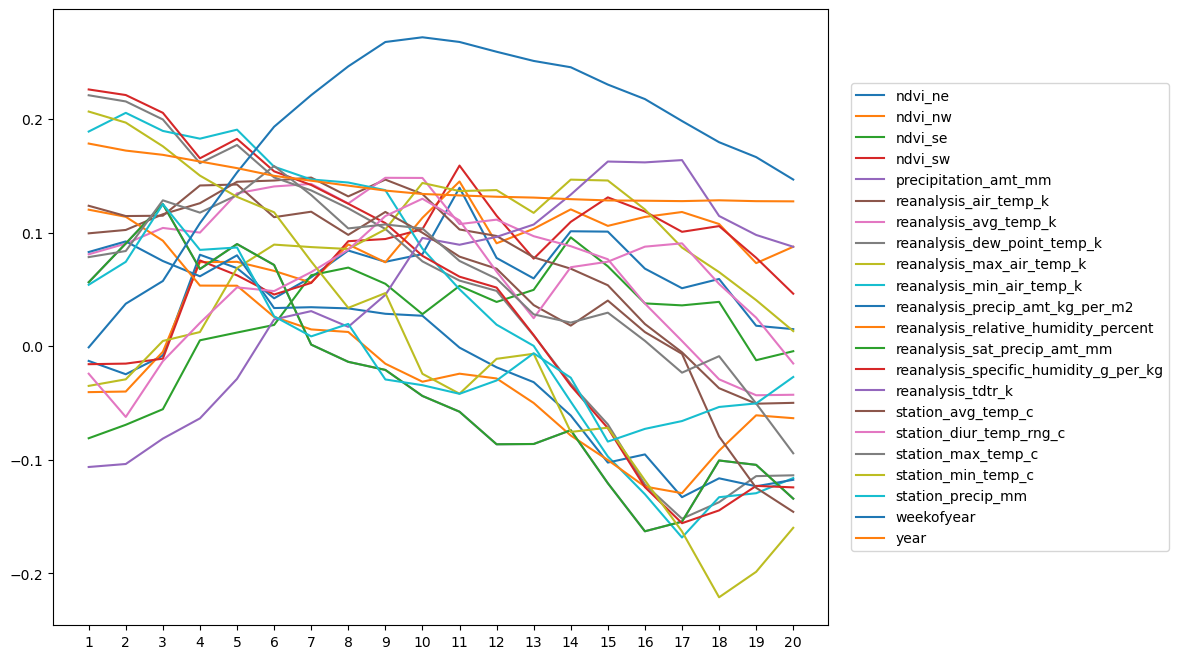

In [12]:
# Plots with lag: "iq" city
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(pd.DataFrame(iq_lag).T)

ax.legend(pd.DataFrame(iq_lag).index,loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.set_xticks(range(1, 21))
plt.show()

In [13]:
pd.DataFrame(iq_lag)

1         2         3         4   \
ndvi_ne                               -0.012951 -0.024668 -0.008232  0.080510   
ndvi_nw                               -0.040422 -0.039899 -0.004897  0.073987   
ndvi_se                               -0.081015 -0.069159 -0.055444  0.005211   
ndvi_sw                               -0.015822 -0.015315 -0.010966  0.075525   
precipitation_amt_mm                   0.056303  0.090427  0.125072  0.067931   
reanalysis_air_temp_k                  0.099359  0.102326  0.116162  0.125867   
reanalysis_avg_temp_k                  0.080896  0.090323  0.104114  0.100001   
reanalysis_dew_point_temp_k            0.220891  0.215446  0.199573  0.161097   
reanalysis_max_air_temp_k             -0.034922 -0.029138  0.004621  0.012473   
reanalysis_min_air_temp_k              0.188951  0.205407  0.189495  0.182680   
reanalysis_precip_amt_kg_per_m2        0.082914  0.092246  0.074993  0.061545   
reanalysis_relative_humidity_percent   0.120177  0.113908  0.092869  0.053363   
reanalysis_sat_precip_amt_mm           0.056303  0.090427  0.125072  0.067931   
reanalysis_specific_humidity_g_per_kg  0.225996  0.221080  0.205429  0.165396   
reanalysis_tdtr_k                     -0.106308 -0.103679 -0.081330 -0.063513   
station_avg_temp_c                     0.123610  0.114572  0.114863  0.141478   
station_diur_temp_rng_c               -0.024194 -0.062252 -0.013192  0.020498   
station_max_temp_c                     0.078431  0.083793  0.128415  0.117569   
station_min_temp_c                     0.206547  0.196819  0.175960  0.150153   
station_precip_mm                      0.054073  0.074275  0.125065  0.084775   
weekofyear                            -0.001007  0.037411  0.057400  0.108276   
year                                   0.178380  0.172190  0.168448  0.162580   

                                             5         6         7         8   \
ndvi_ne                                0.068708  0.042149  0.060690  0.084223   
ndvi_nw                                0.074260  0.066299  0.055952  0.089520   
ndvi_se                                0.012026  0.018720  0.062487  0.069200   
ndvi_sw                                0.062402  0.045496  0.055724  0.092425   
precipitation_amt_mm                   0.089914  0.071517  0.001406 -0.013753   
reanalysis_air_temp_k                  0.144738  0.145818  0.148431  0.131866   
reanalysis_avg_temp_k                  0.134579  0.140627  0.142827  0.125645   
reanalysis_dew_point_temp_k            0.177126  0.148564  0.137133  0.121369   
reanalysis_max_air_temp_k              0.068795  0.089433  0.087245  0.085568   
reanalysis_min_air_temp_k              0.190609  0.158015  0.146766  0.144078   
reanalysis_precip_amt_kg_per_m2        0.080013  0.033583  0.034329  0.033280   
reanalysis_relative_humidity_percent   0.053239  0.025762  0.014772  0.012535   
reanalysis_sat_precip_amt_mm           0.089914  0.071517  0.001406 -0.013753   
reanalysis_specific_humidity_g_per_kg  0.182487  0.153936  0.141907  0.125387   
reanalysis_tdtr_k                     -0.028734  0.023542  0.030881  0.017041   
station_avg_temp_c                     0.142333  0.113577  0.118393  0.098001   
station_diur_temp_rng_c                0.051780  0.048527  0.065242  0.084931   
station_max_temp_c                     0.132940  0.158640  0.133082  0.103689   
station_min_temp_c                     0.131445  0.117866  0.074655  0.033760   
station_precip_mm                      0.086913  0.026295  0.008664  0.019609   
weekofyear                             0.152927  0.193165  0.221003  0.246327   
year                                   0.156746  0.149945  0.145685  0.141343   

                                             9         10        11        12  \
ndvi_ne                                0.074288  0.081046  0.139497  0.077665   
ndvi_nw                                0.073880  0.113011  0.144999  0.090597   
ndvi_se                                0.054939  0.028225  0.053100  0.038

### f. Hirerachical clustering

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/417332026.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sj_quasi_diag = quasi_diag(sj_data.corr(), method = 'complete')
/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/417332026.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix , method='single')


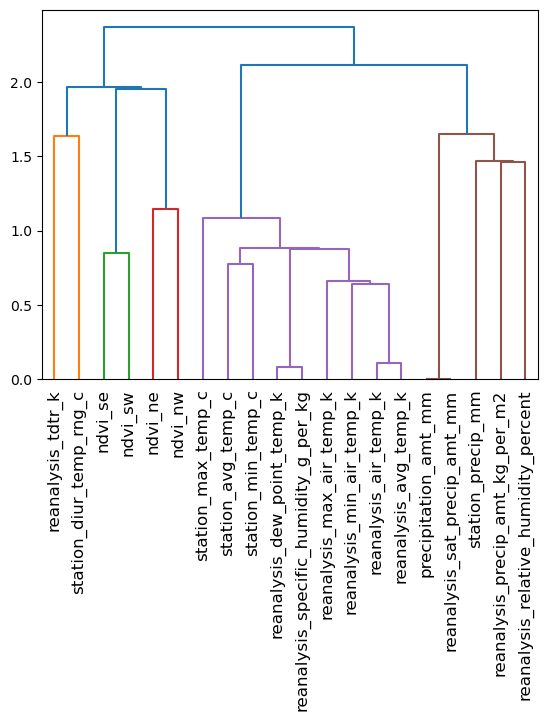

In [14]:
# f. Hirerachical clustering: "sj" city
def quasi_diag(correlation_matrix, method = 'single'):
    distance_matrix = np.sqrt(2 * (1 - correlation_matrix))
    linkage_matrix = hierarchy.linkage(distance_matrix , method='single')
    sort_ix = hierarchy.leaves_list(linkage_matrix)
    
    quasi_diag_cov = pd.DataFrame(correlation_matrix.iloc[sort_ix, sort_ix])
    hierarchy.dendrogram(linkage_matrix, labels =correlation_matrix.columns, orientation = 'top',leaf_rotation = 90 )
    return quasi_diag_cov

columns_to_exclude = ["weekofyear", "year", "total_cases"]
sj_data = df.drop(columns=columns_to_exclude)[df['city'] == 'sj']
sj_quasi_diag = quasi_diag(sj_data.corr(), method = 'complete')

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/3661781050.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  iq_quasi_diag = quasi_diag(iq_data.corr(), method = 'complete')
/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/417332026.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix , method='single')


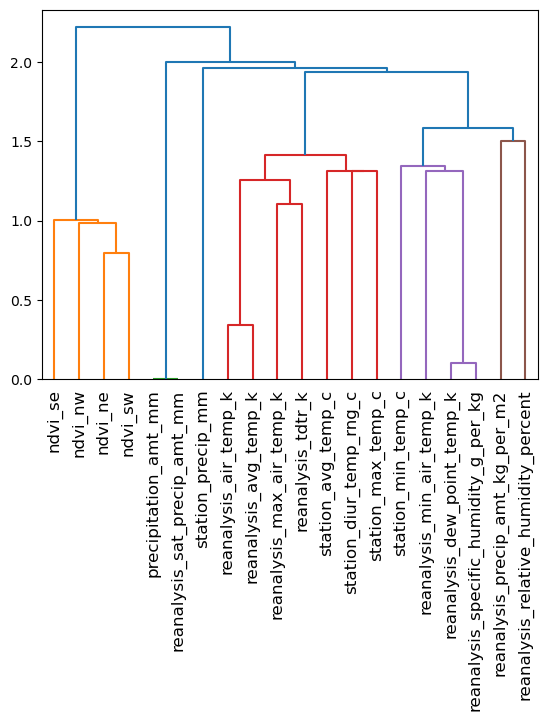

In [15]:
# Hirerachical clustering: "iq" city
iq_data = df.drop(columns=columns_to_exclude)[df['city'] == 'iq']
iq_quasi_diag = quasi_diag(iq_data.corr(), method = 'complete')

### g. Outliers

/Users/zy/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


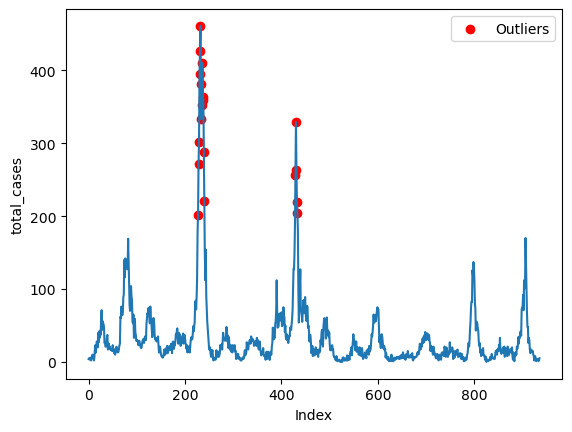

In [16]:
# g. Outlier: "sj" city
def plot_outliers(df):
    # Assuming df has a numeric index
    df.reset_index(drop=True, inplace=True)

    iforest = IsolationForest(n_estimators=100, contamination=0.02)

    # Fit and predict on the 'total_cases' column
    pred = iforest.fit_predict(df[['total_cases']])
    score = iforest.decision_function(df[['total_cases']])

    # Extracting anomalies
    anomaly_index = np.where(pred == -1)
    anomaly_values = df.iloc[anomaly_index]

    # Scatter plot with anomalies
    plt.plot(df.index, df['total_cases'])
    plt.scatter(anomaly_values.index, anomaly_values['total_cases'], color='r', label='Outliers')
    plt.xlabel("Index")
    plt.ylabel("total_cases")
    plt.legend()
    plt.show()

# Call the function with the 'total_cases' data
sj_data = df[df['city'] == 'sj']
plot_outliers(sj_data[['week_start_date', 'total_cases']])

/Users/zy/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


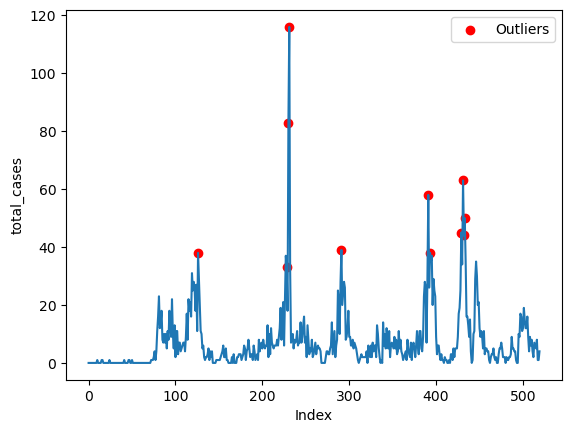

In [17]:
# Outlier: "iq" city
iq_data = df[df['city'] == 'iq']
plot_outliers(iq_data[['week_start_date', 'total_cases']])

## 3. Plots for all predictors

### a. Distribution

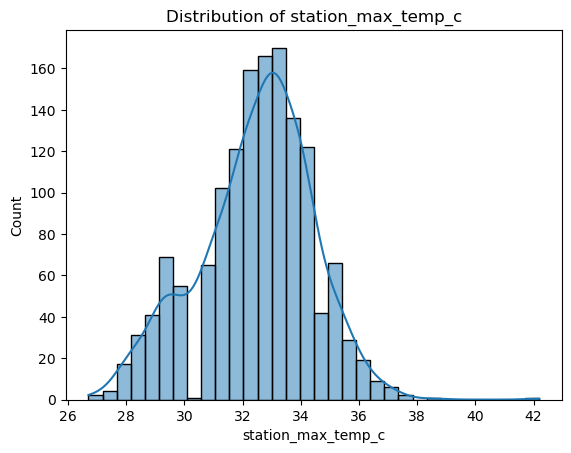

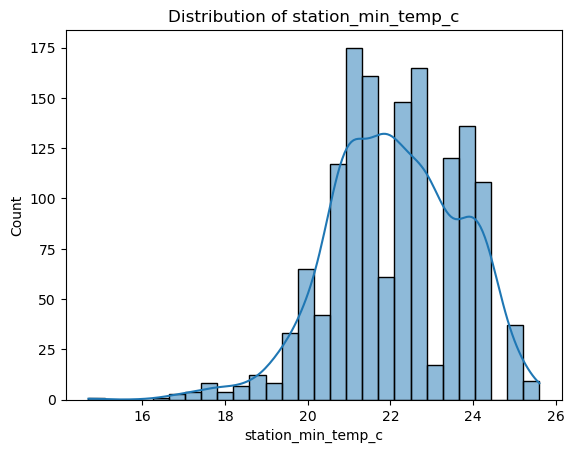

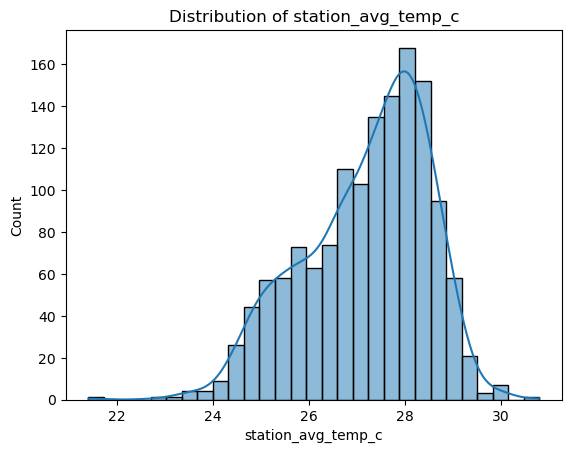

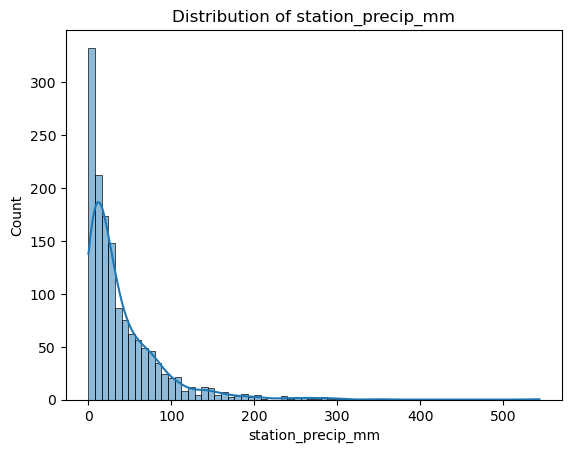

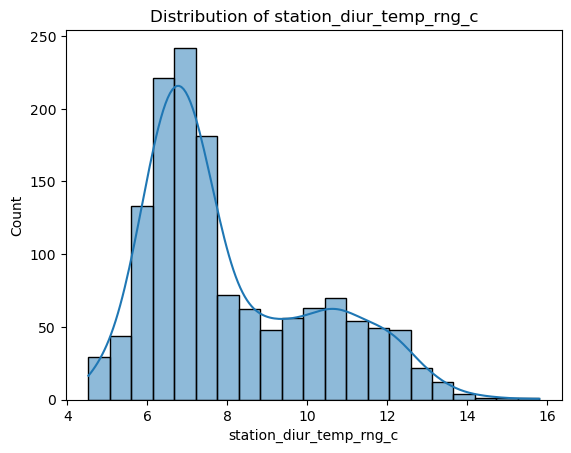

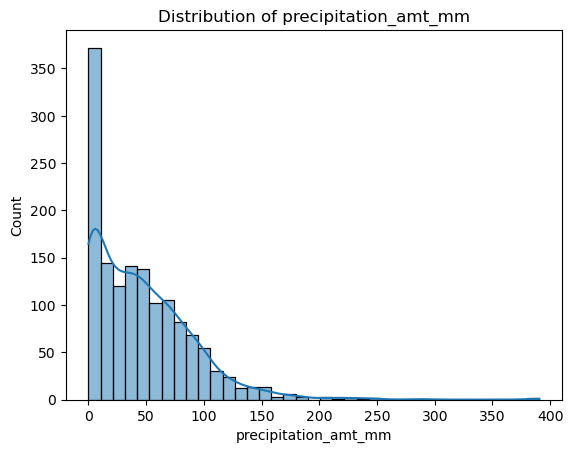

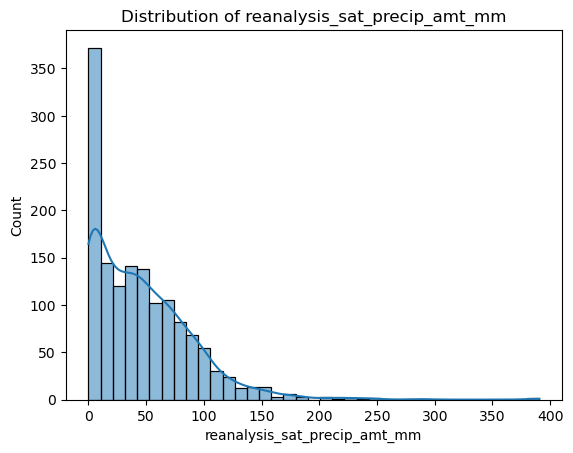

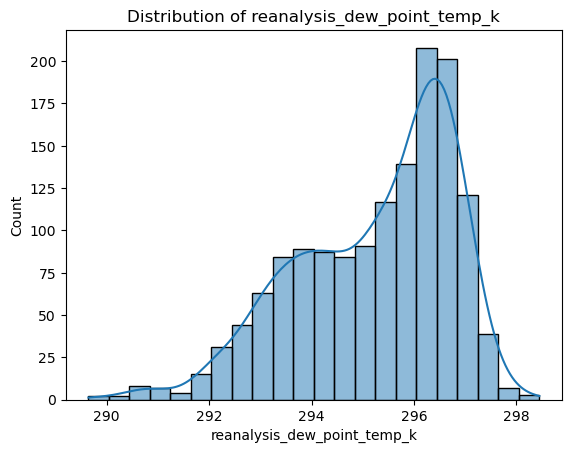

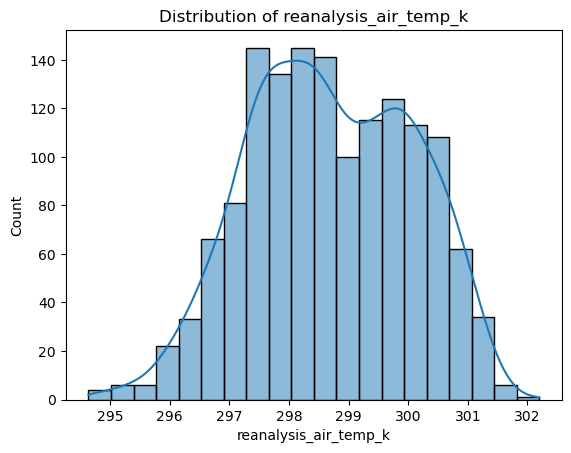

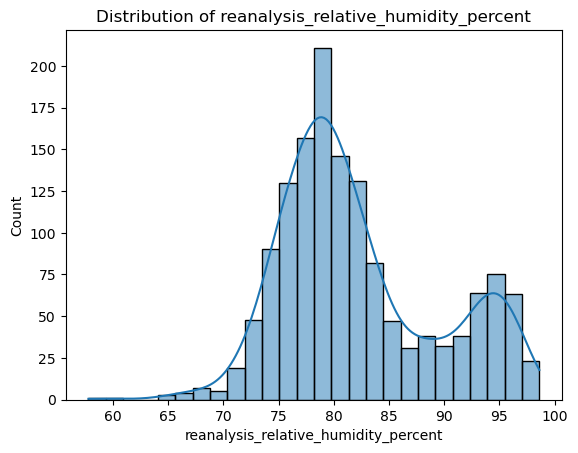

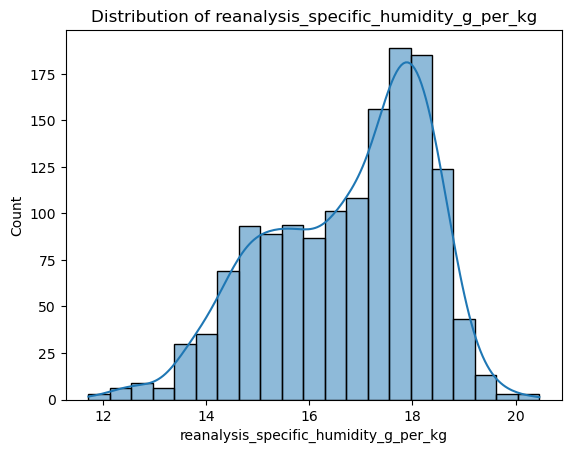

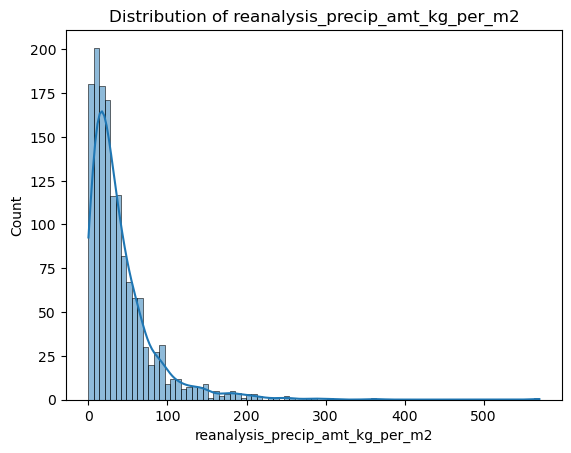

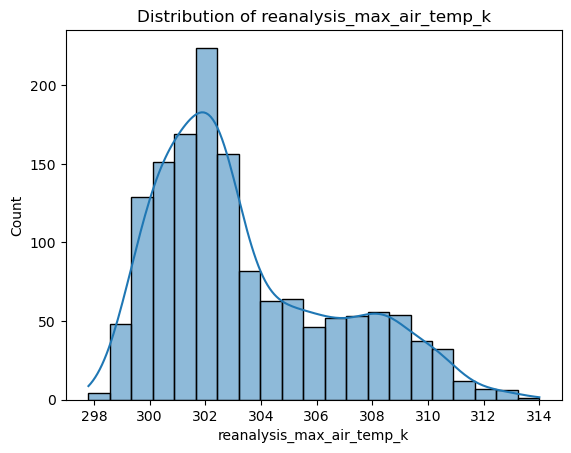

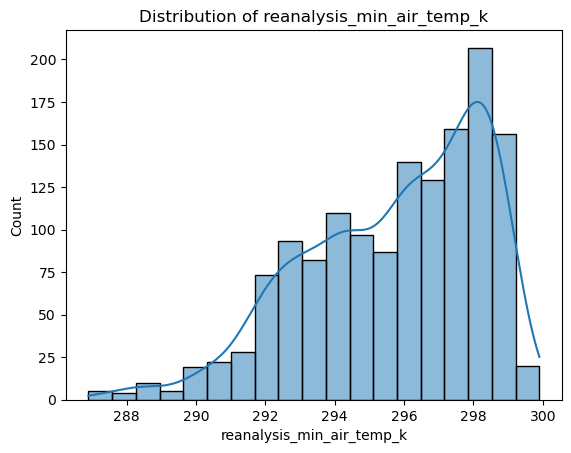

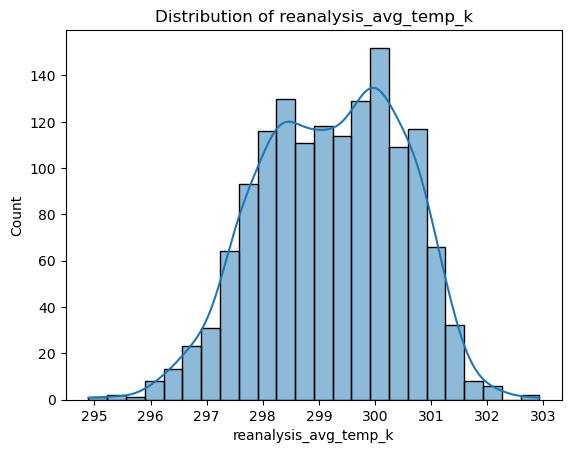

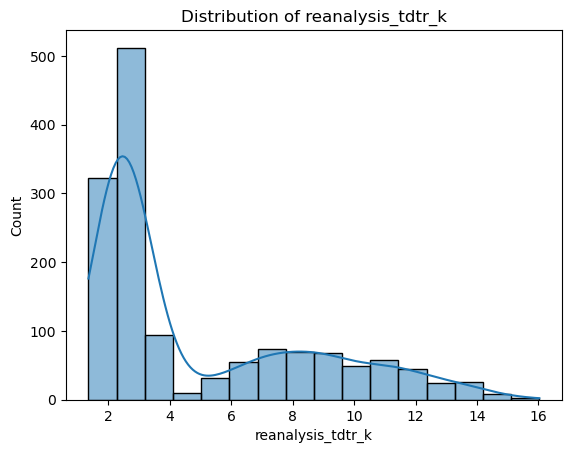

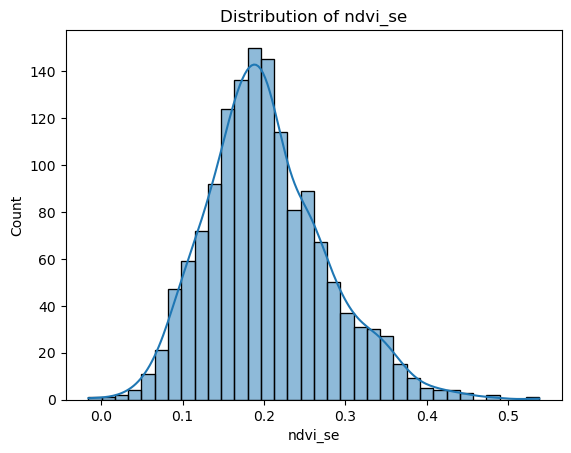

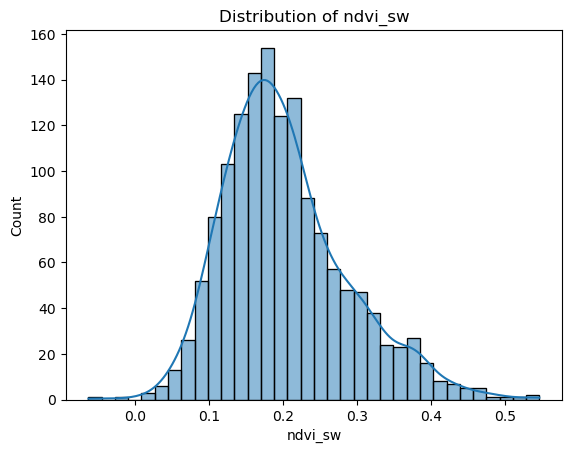

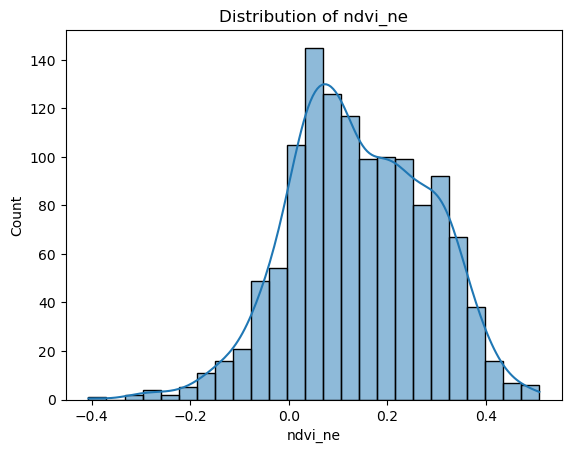

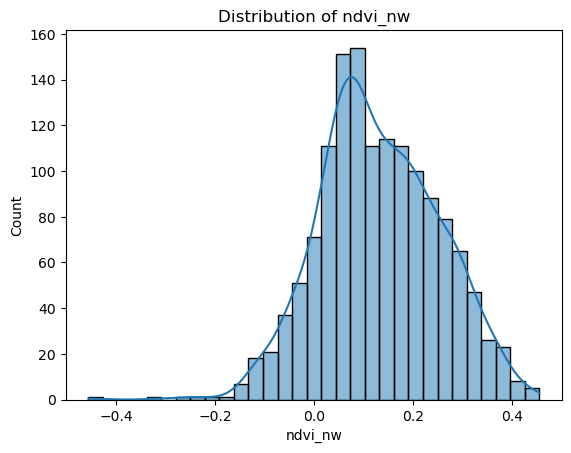

In [18]:
## 3. Plots for all predictors
# a. Distribution: overall
numerical_features = [
    'station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
    'station_precip_mm', 'station_diur_temp_rng_c', 'precipitation_amt_mm',
    'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k',
    'reanalysis_air_temp_k', 'reanalysis_relative_humidity_percent',
    'reanalysis_specific_humidity_g_per_kg', 'reanalysis_precip_amt_kg_per_m2',
    'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
    'reanalysis_avg_temp_k', 'reanalysis_tdtr_k',
    'ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw'
]

for feature in numerical_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

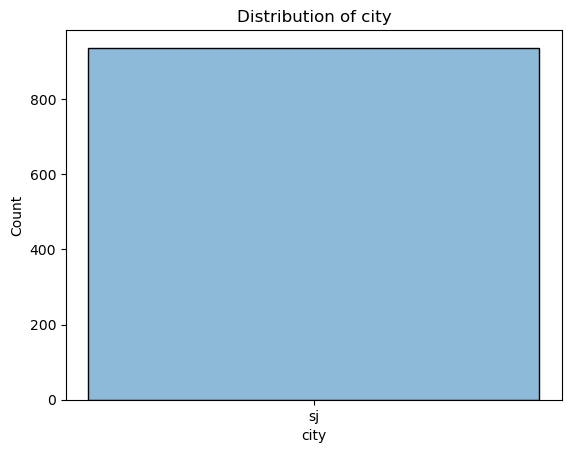

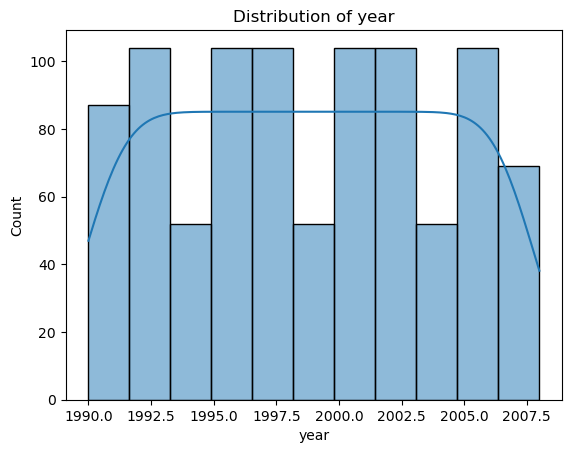

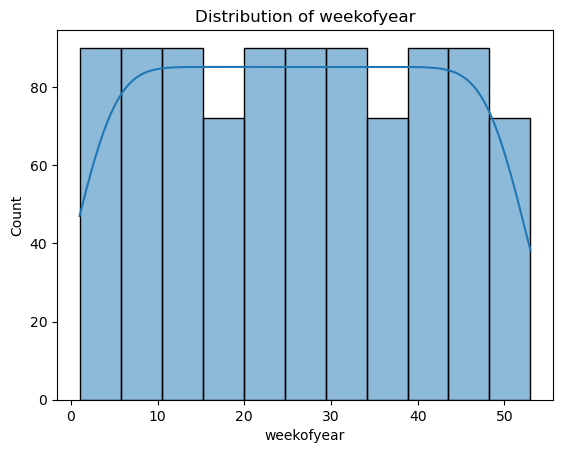

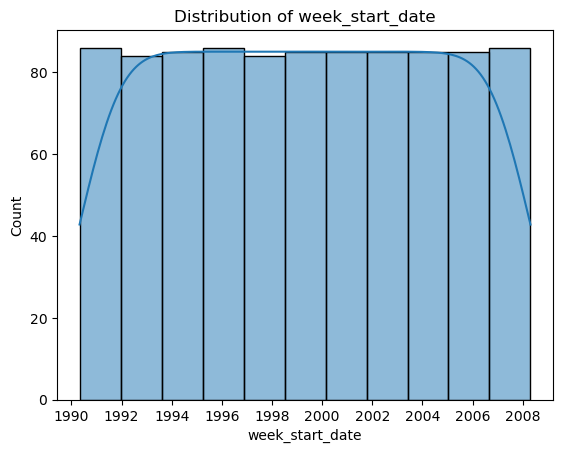

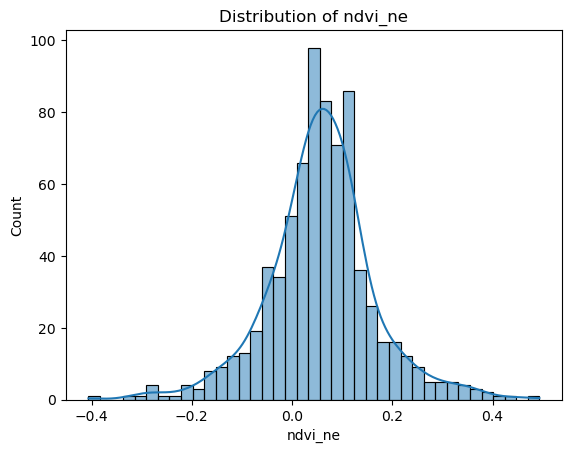

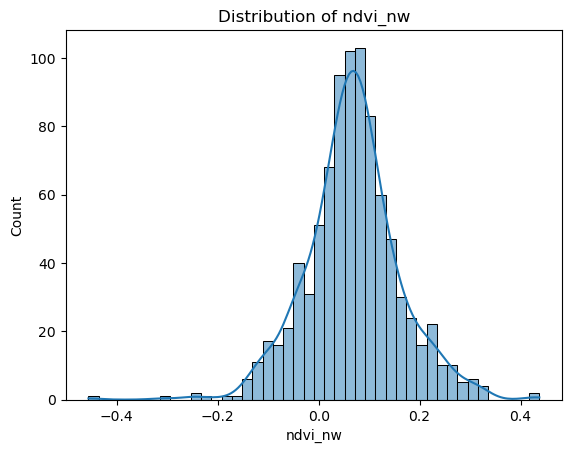

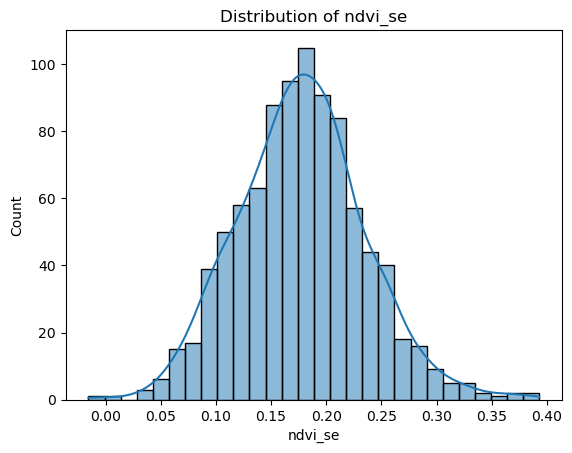

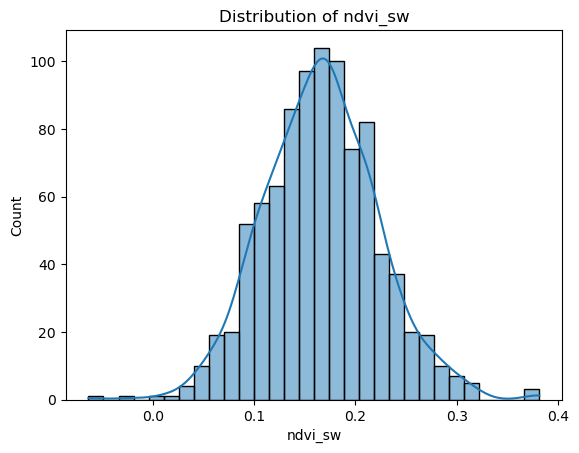

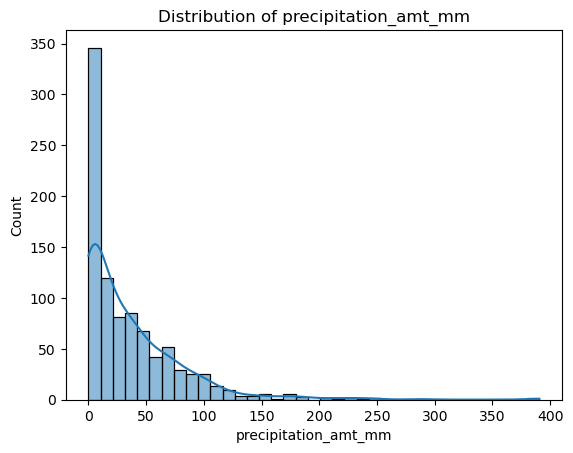

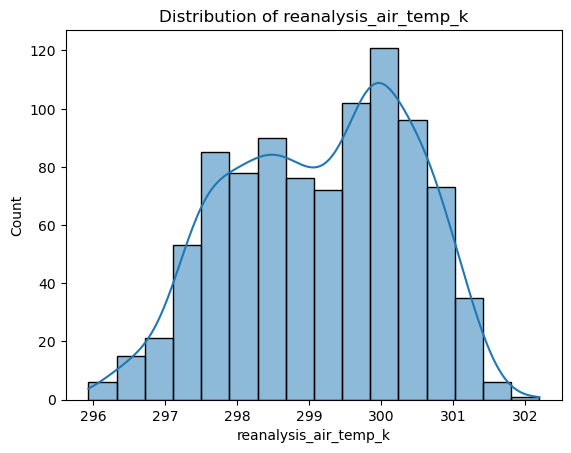

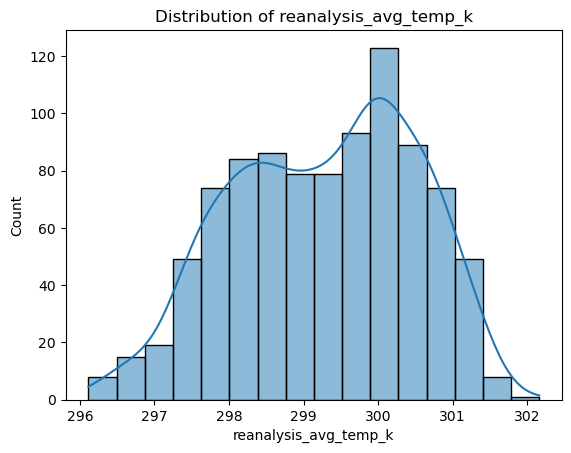

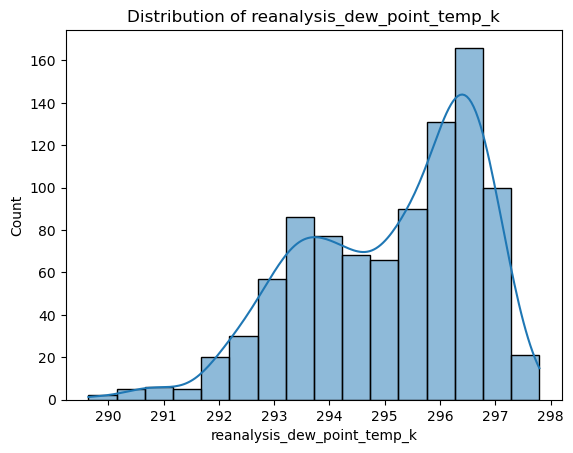

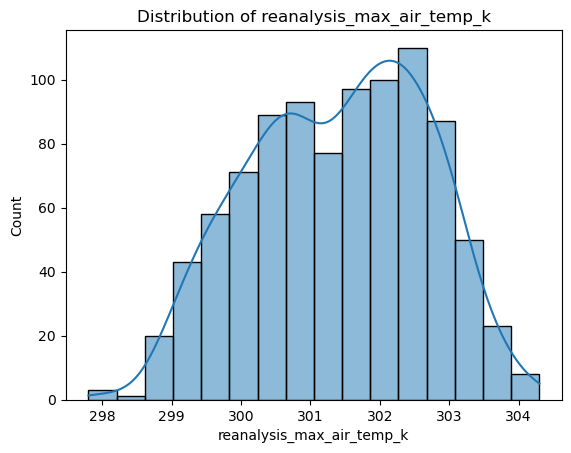

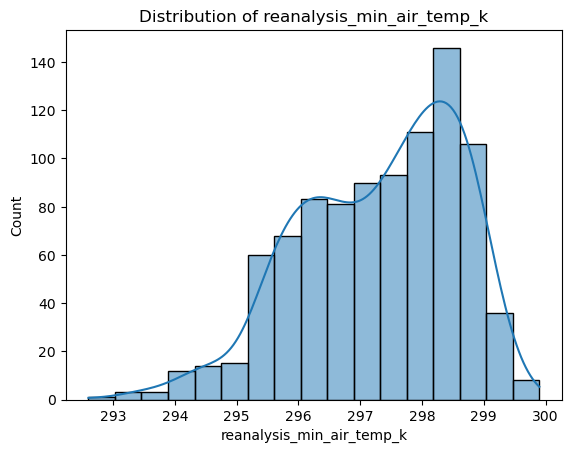

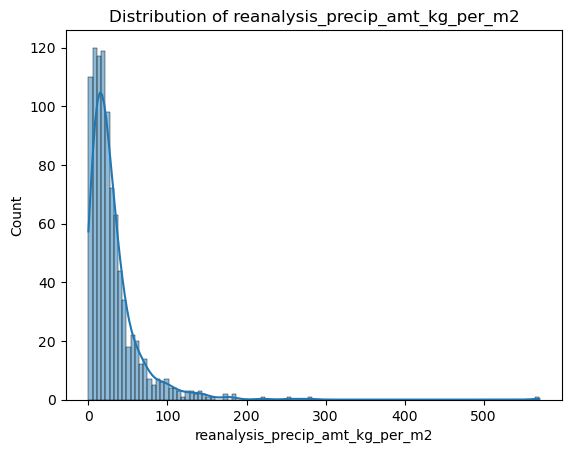

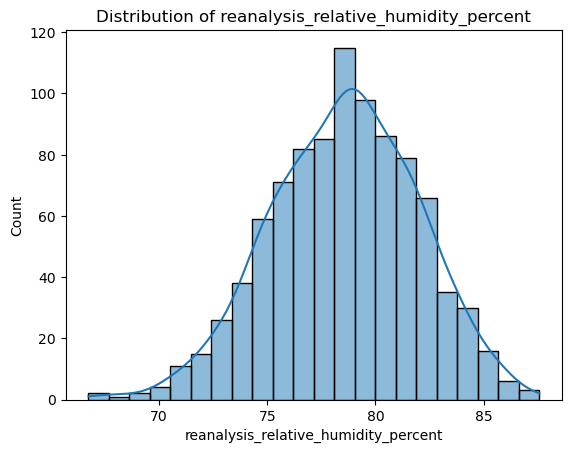

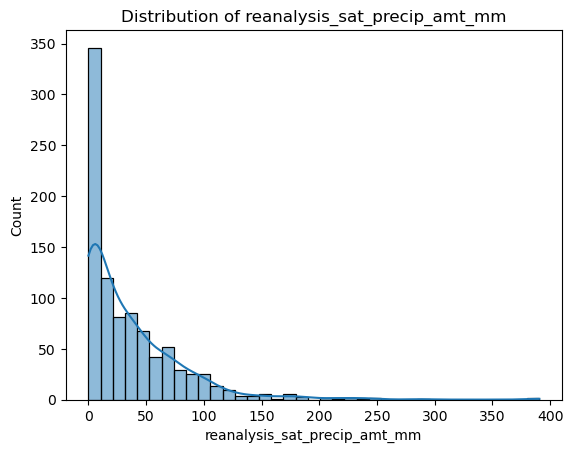

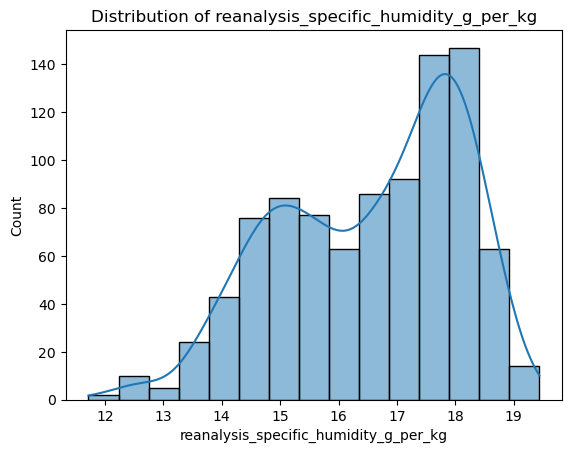

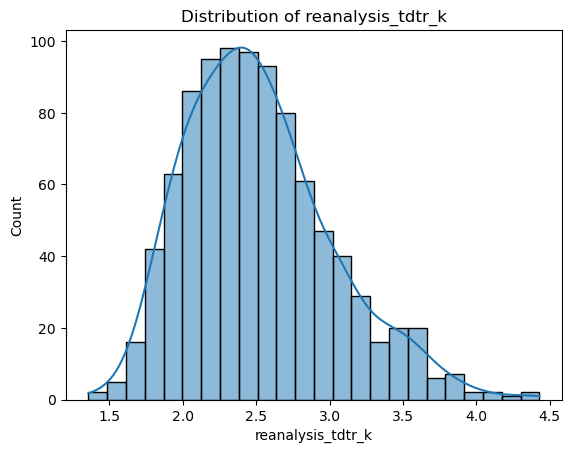

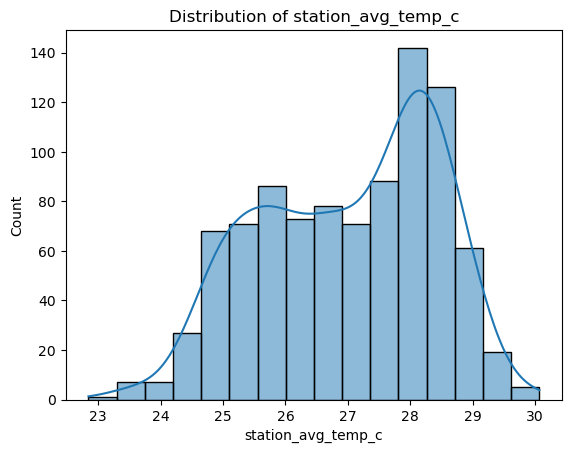

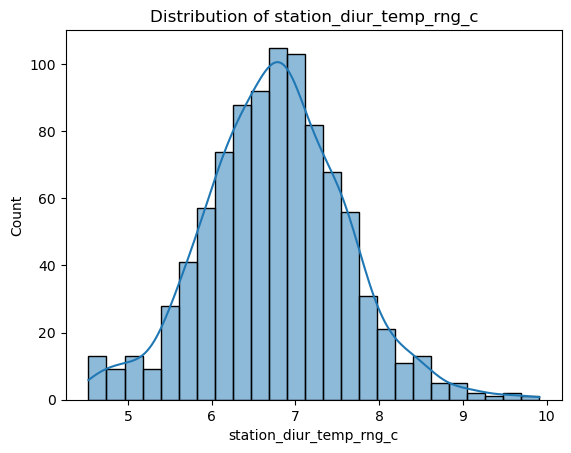

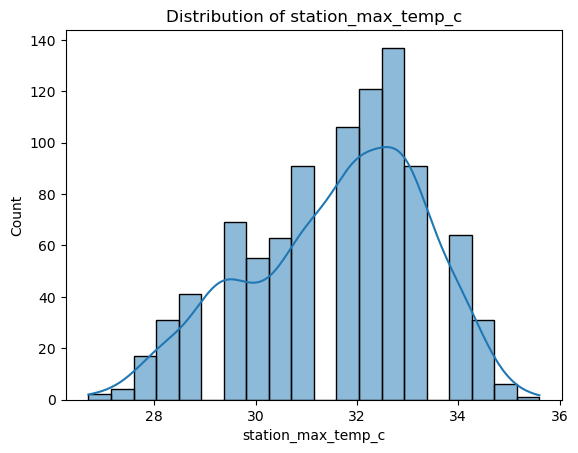

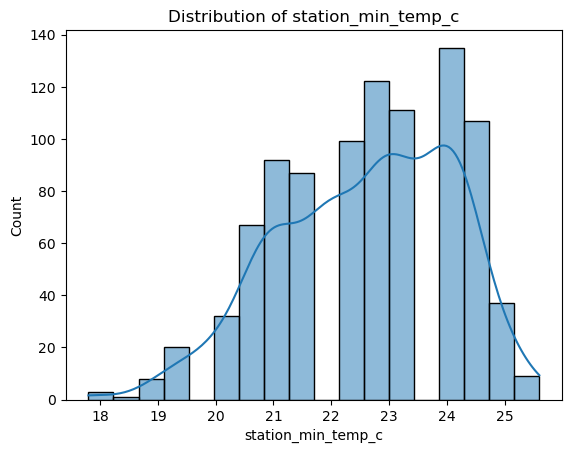

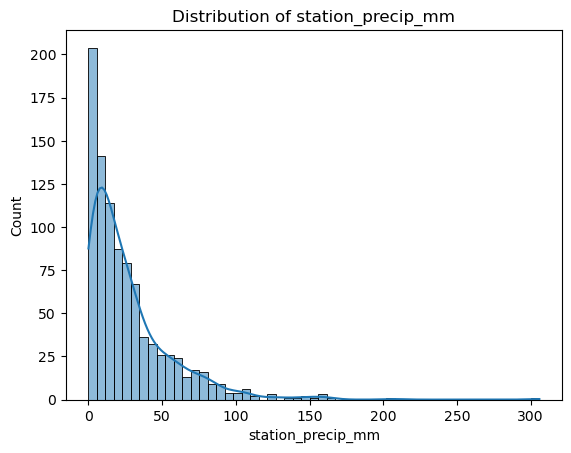

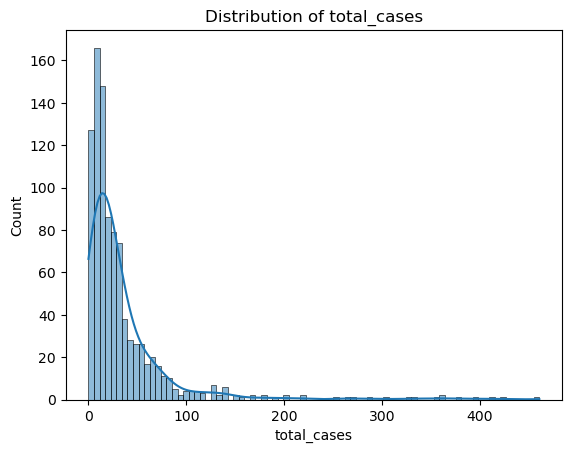

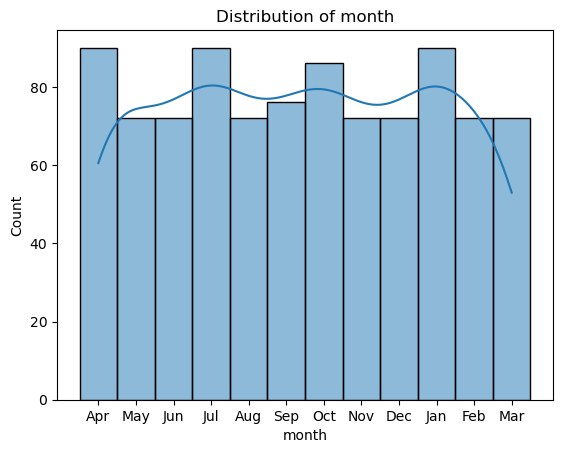

In [19]:
# Distribution: "sj" city
def plot_distribution(ts,name):
    sns.histplot(ts, kde=True)
    plt.title(f"Distribution of {name}")
    plt.show()
    
sj_data = df[df['city'] == 'sj']
for var in sj_data.columns:
    plot_distribution(sj_data[var],var)

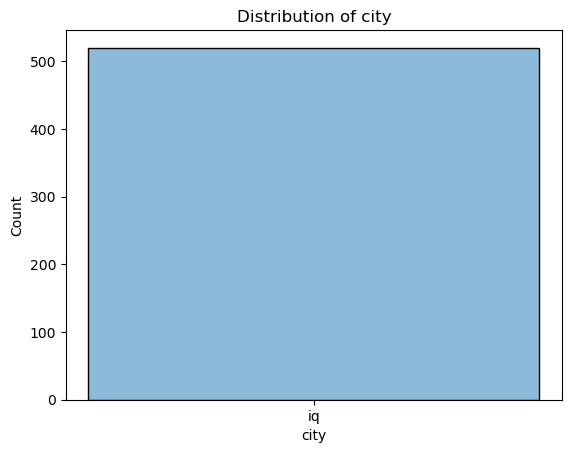

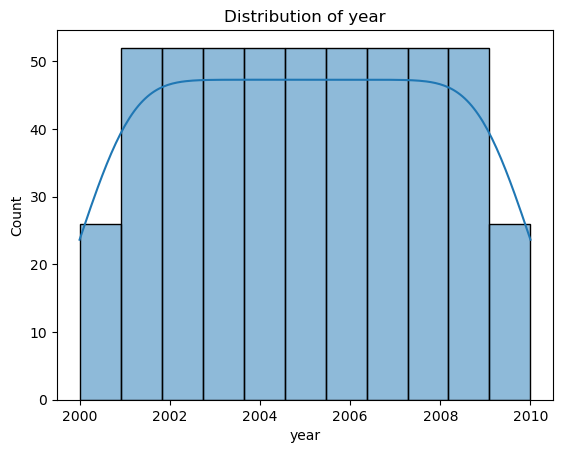

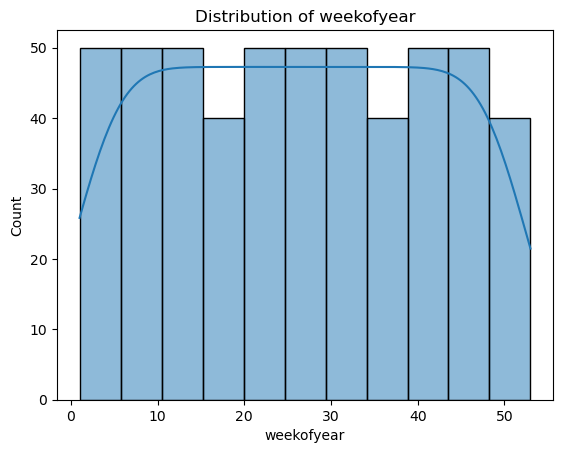

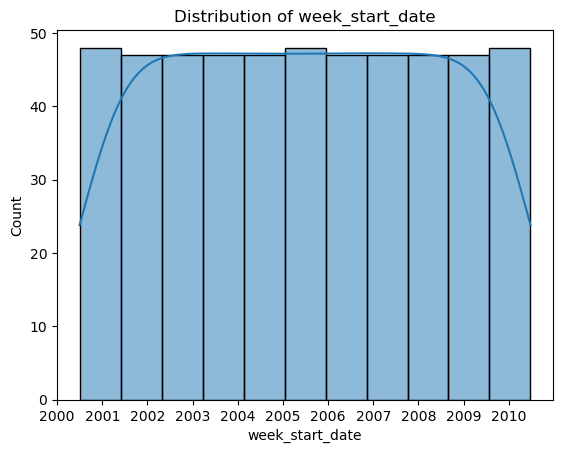

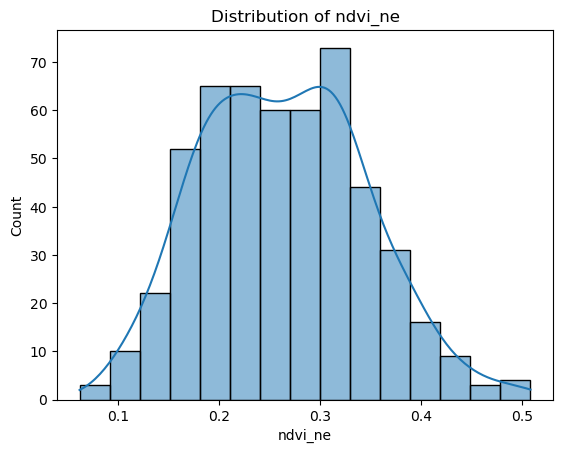

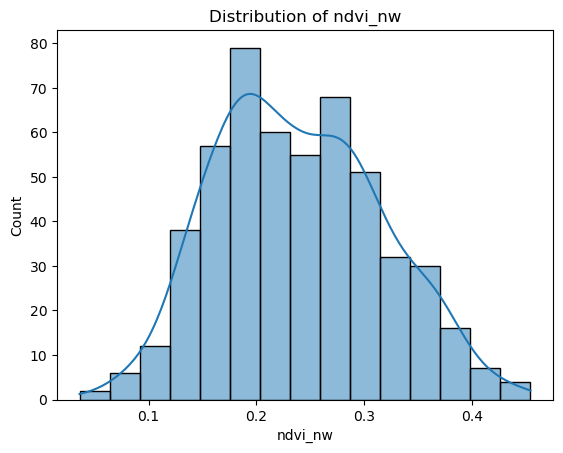

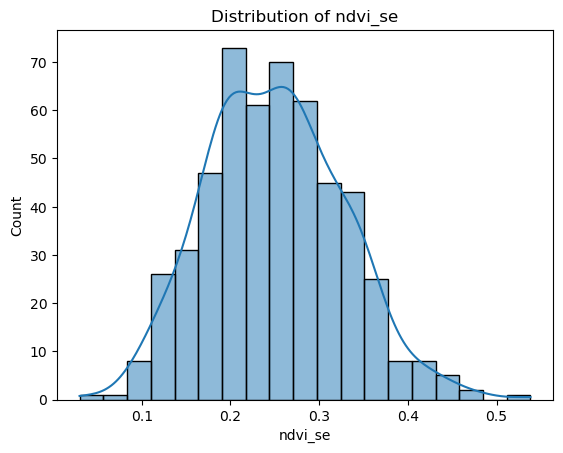

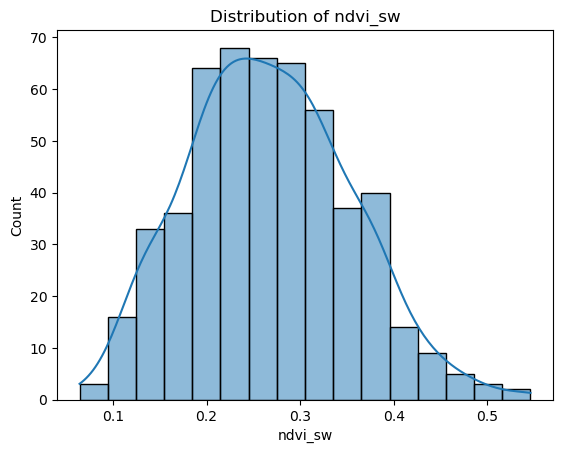

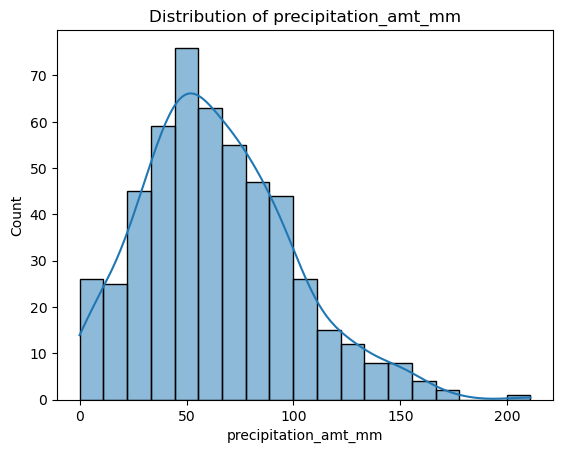

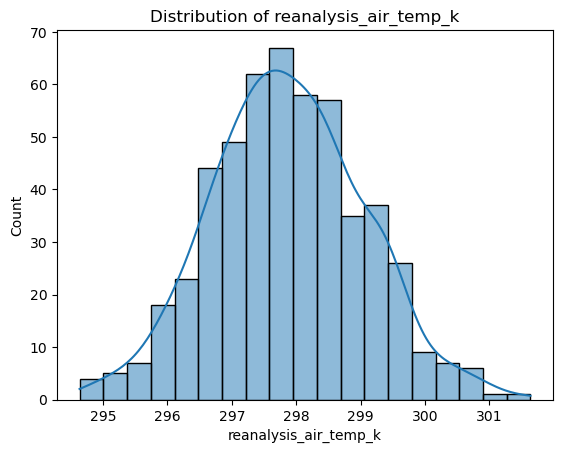

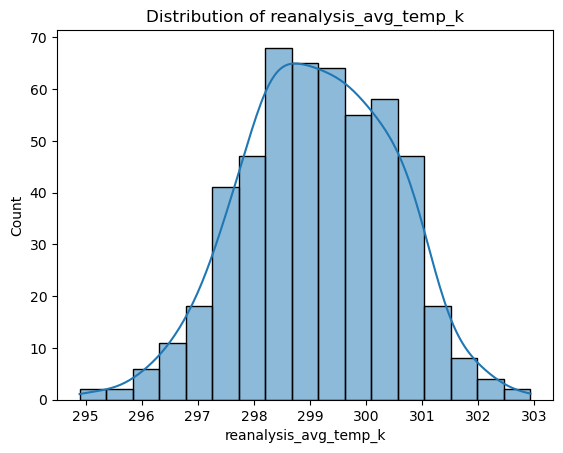

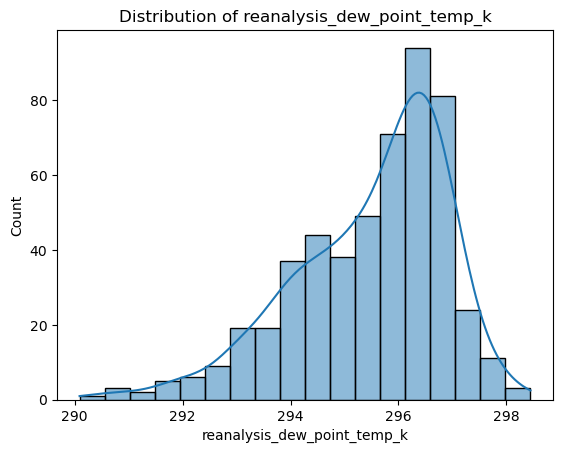

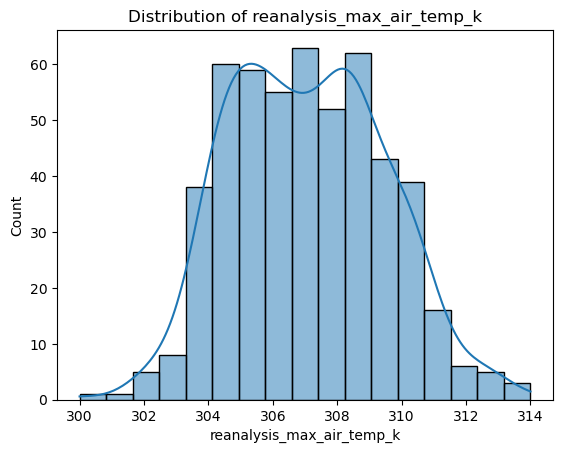

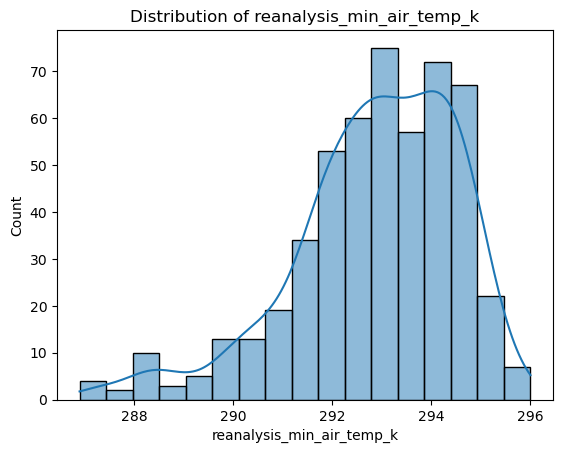

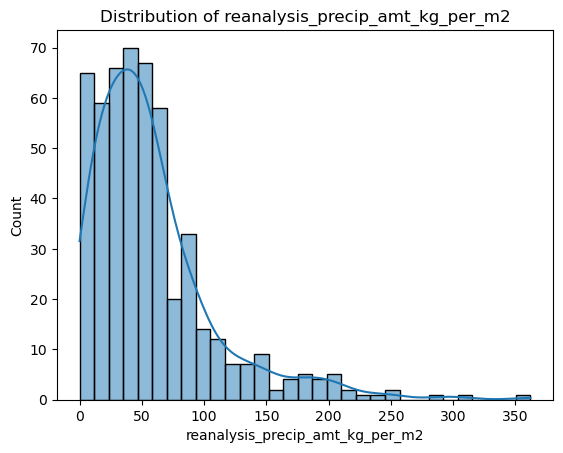

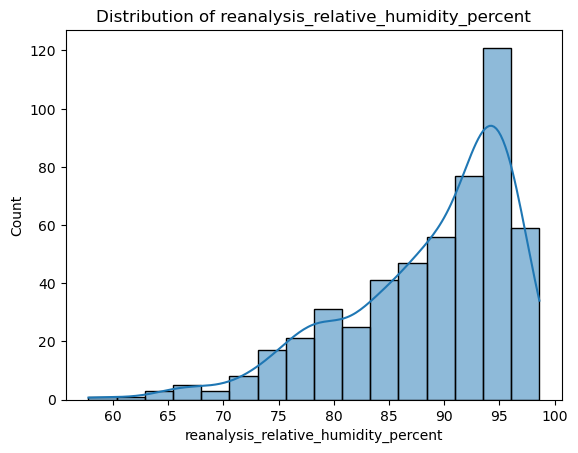

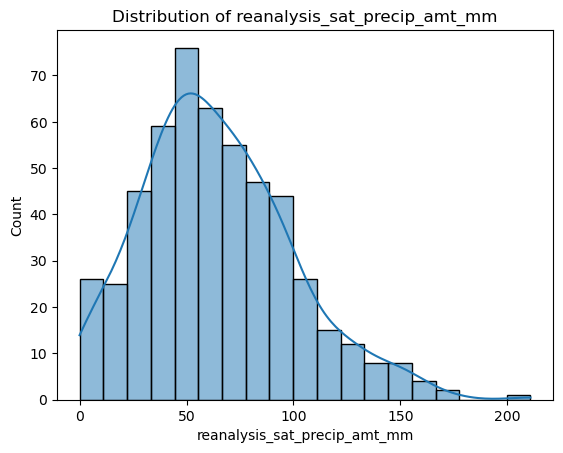

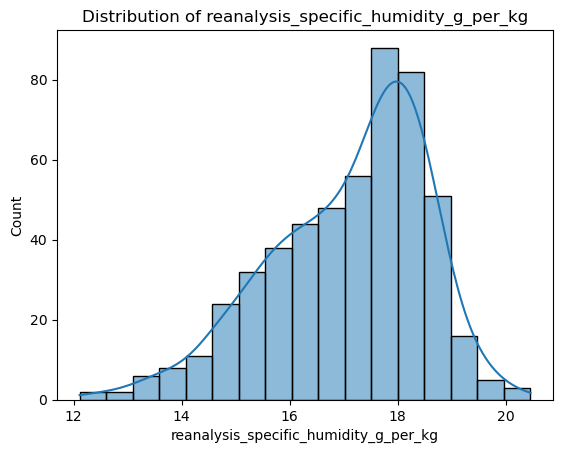

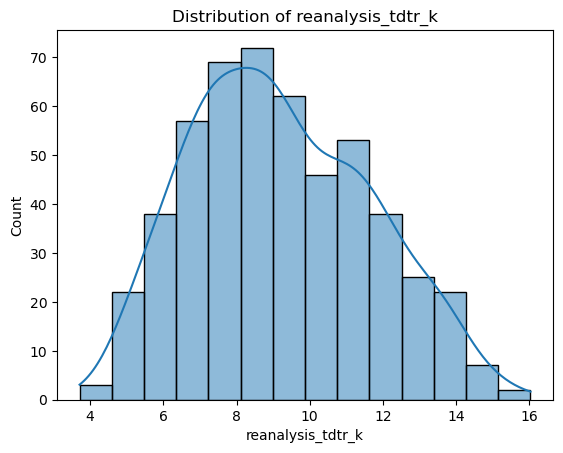

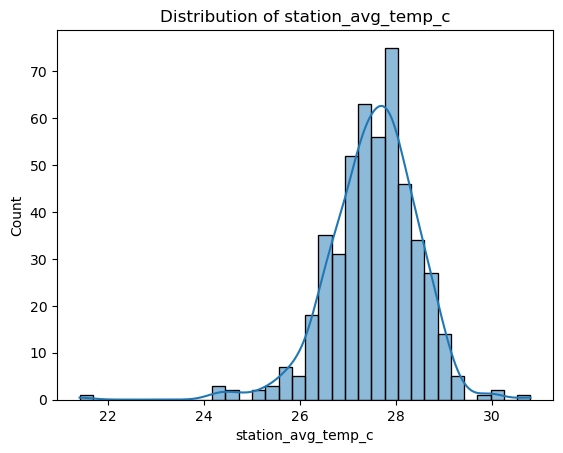

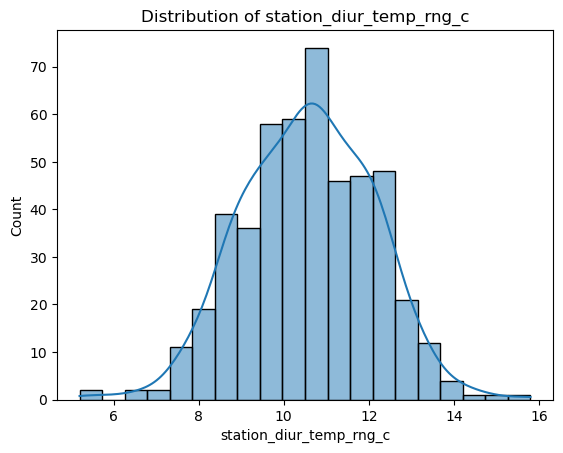

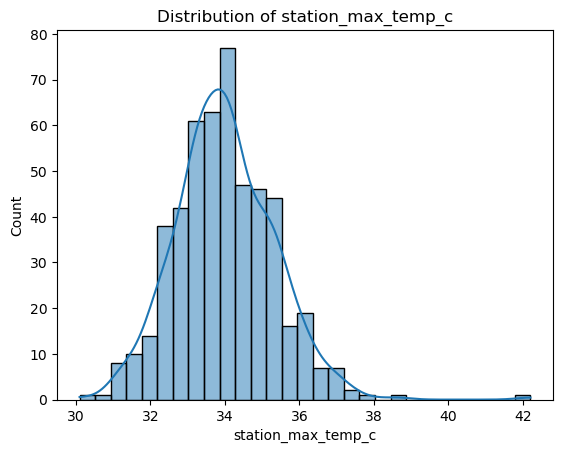

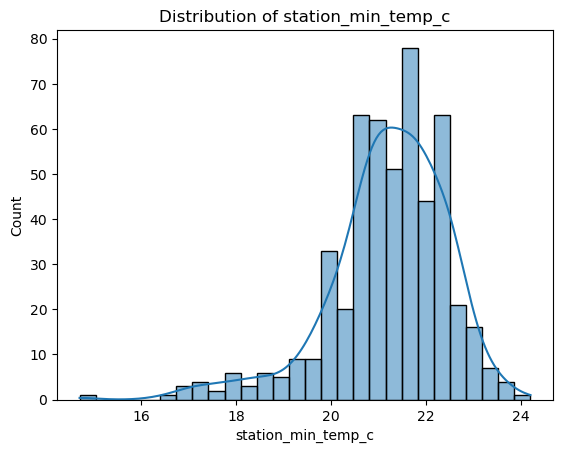

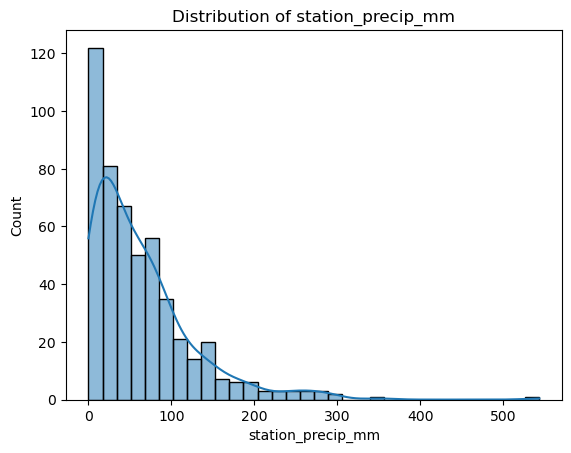

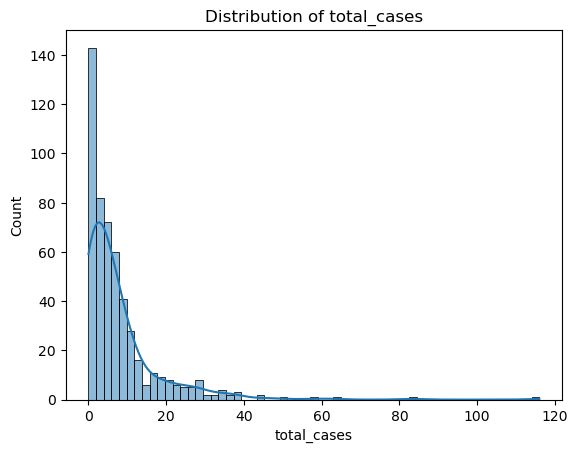

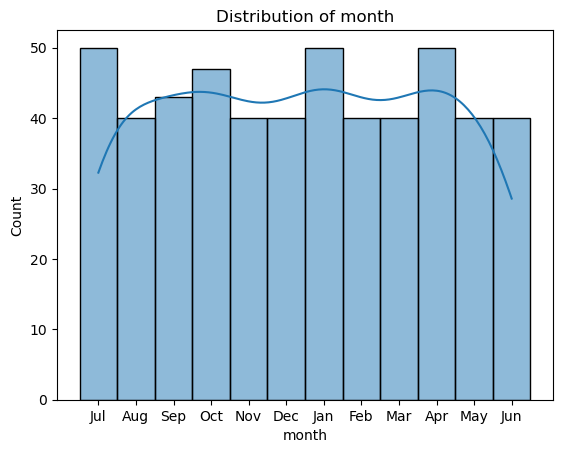

In [20]:
# Distribution: "iq" city
iq_data = df[df['city'] == 'iq']
for var in iq_data.columns:
    plot_distribution(iq_data[var],var)

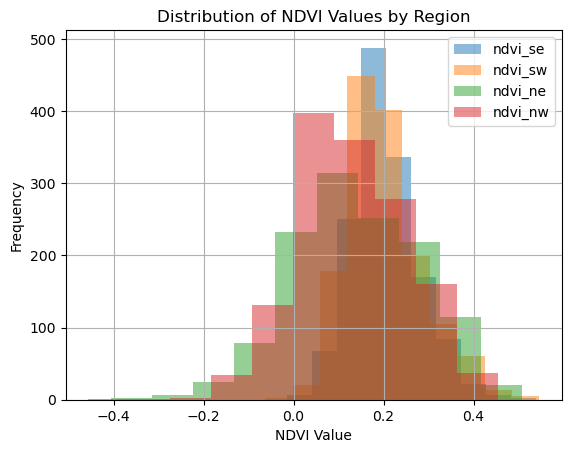

In [21]:
# Distribution: NDVI values
ndvi_features = ['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

for feature in ndvi_features:
    df[feature].hist(label=feature, alpha=0.5)

plt.legend()
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('Distribution of NDVI Values by Region')
plt.show()

### b. Scatter plot 

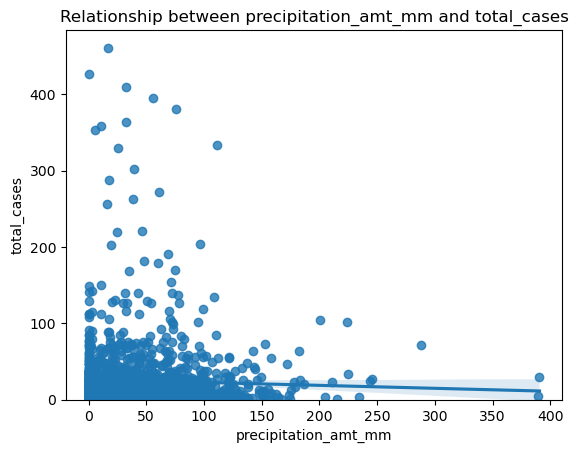

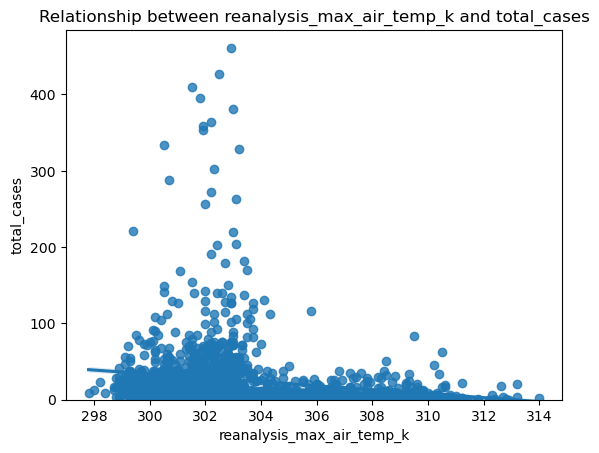

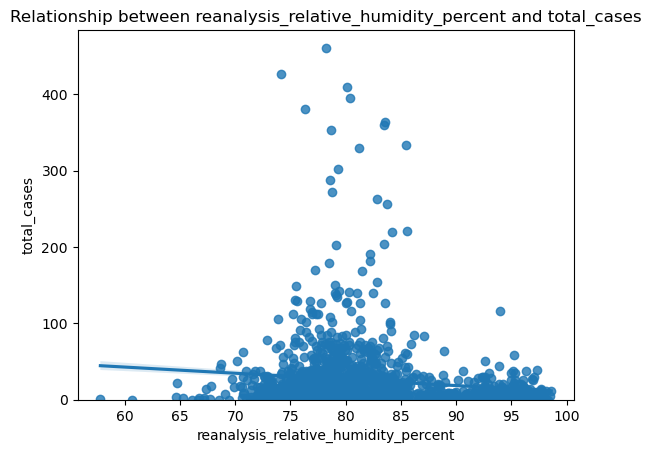

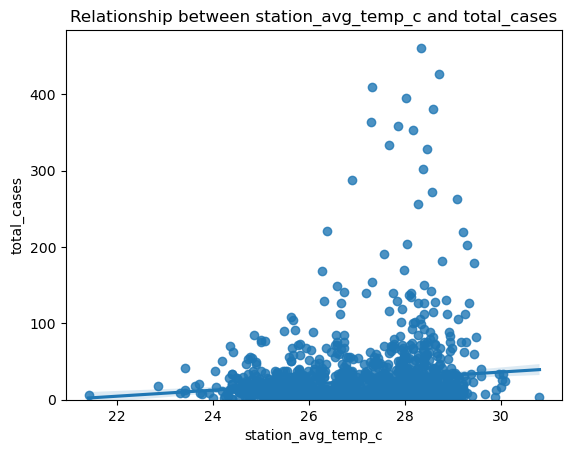

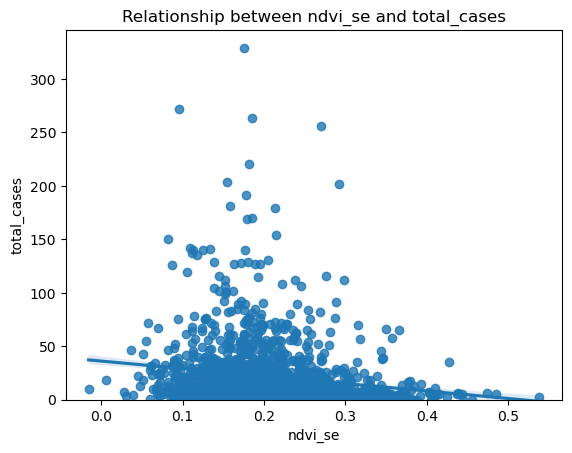

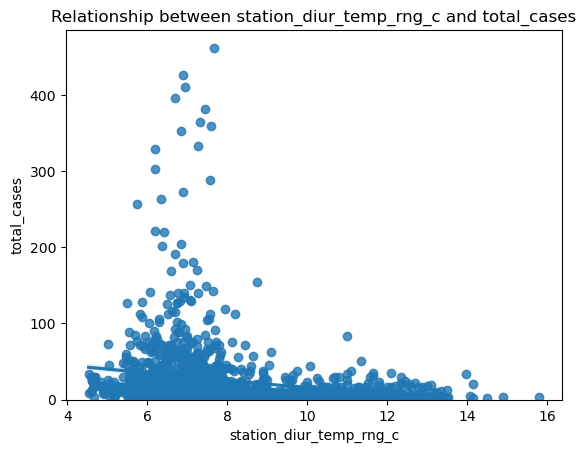

In [22]:
# b. Scatter plot 
features = ["precipitation_amt_mm", "reanalysis_max_air_temp_k", "reanalysis_relative_humidity_percent",
           "station_avg_temp_c", "ndvi_se", "station_diur_temp_rng_c"]

for feature in features:
    sns.regplot(x=feature, y="total_cases", data=df)
    plt.ylim(0,)
    plt.title(f"Relationship between {feature} and total_cases")
    plt.show()

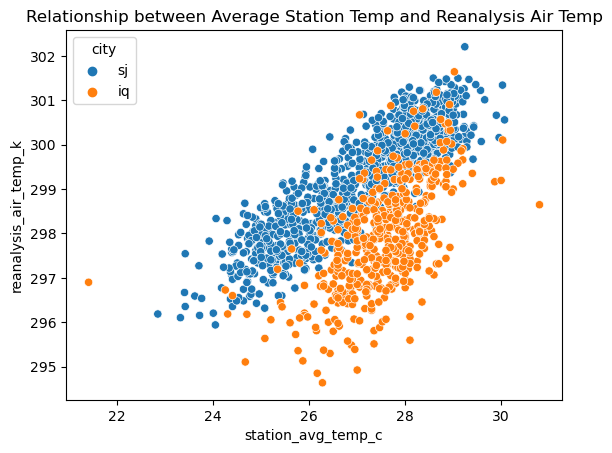

In [23]:
# Scatter plot: Average Station Temp and Reanalysis Air Temp
sns.scatterplot(x='station_avg_temp_c', y='reanalysis_air_temp_k', hue='city', data=df)
plt.title("Relationship between Average Station Temp and Reanalysis Air Temp")
plt.show()

(0.0, 484.237354298552)

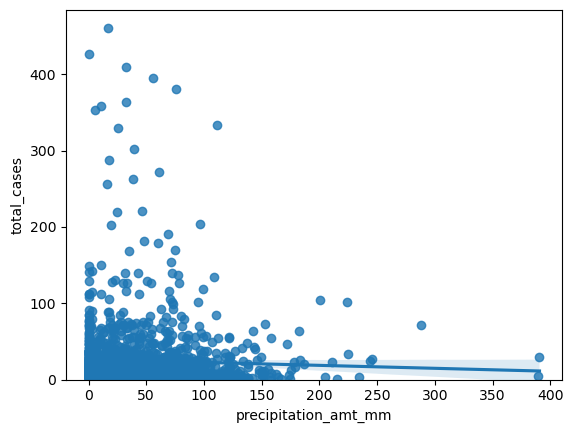

In [3]:
sns.regplot(x="precipitation_amt_mm", y="total_cases", data=df)
plt.ylim(0,)

(0.0, 484.3373462076628)

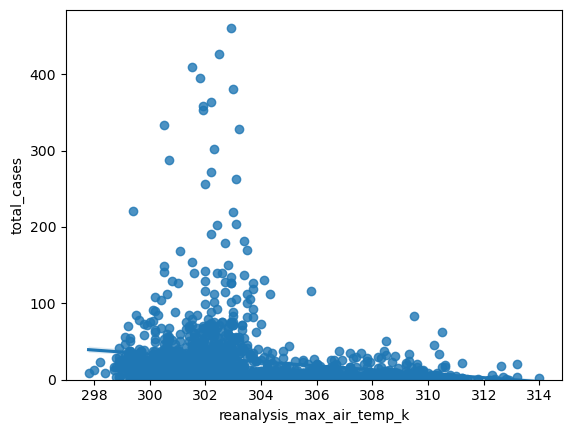

In [4]:
sns.regplot(x="reanalysis_max_air_temp_k", y="total_cases", data=df)
plt.ylim(0,)

(0.0, 484.05)

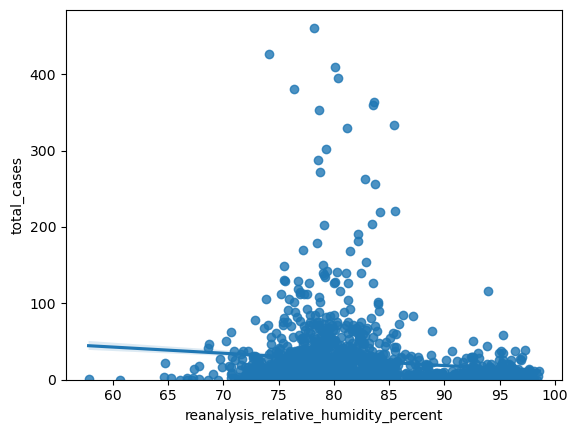

In [5]:
sns.regplot(x="reanalysis_relative_humidity_percent", y="total_cases", data=df)
plt.ylim(0,)

(0.0, 484.32288374200357)

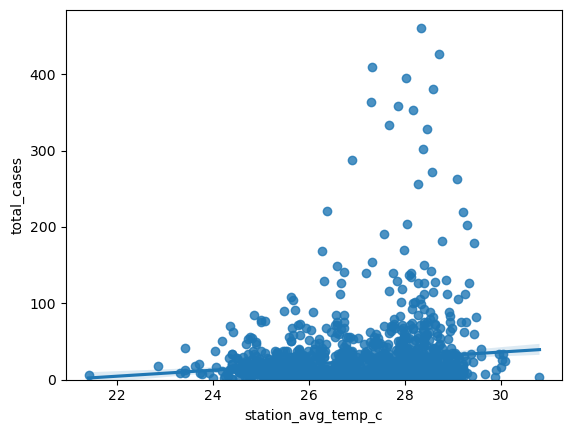

In [6]:
sns.regplot(x="station_avg_temp_c", y="total_cases", data=df)
plt.ylim(0,)

(0.0, 345.7962217719027)

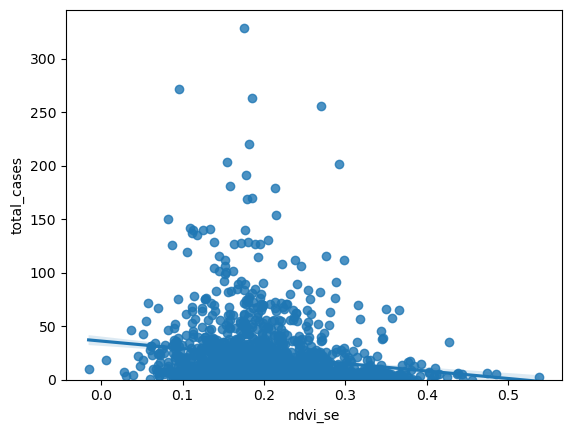

In [7]:
sns.regplot(x="ndvi_se", y="total_cases", data=df)
plt.ylim(0,)

(0.0, 484.91553578279024)

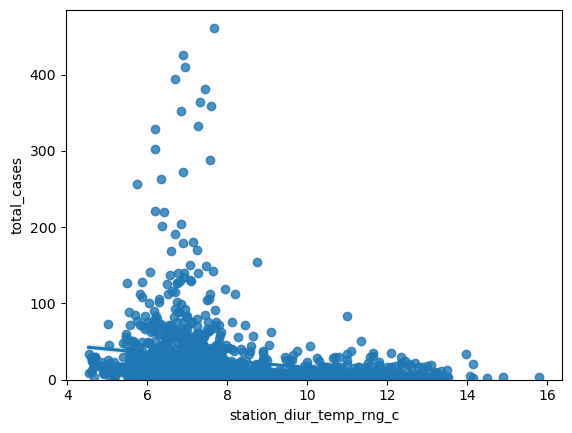

In [8]:
sns.regplot(x="station_diur_temp_rng_c", y="total_cases", data=df)
plt.ylim(0,)

### c. Over time plot

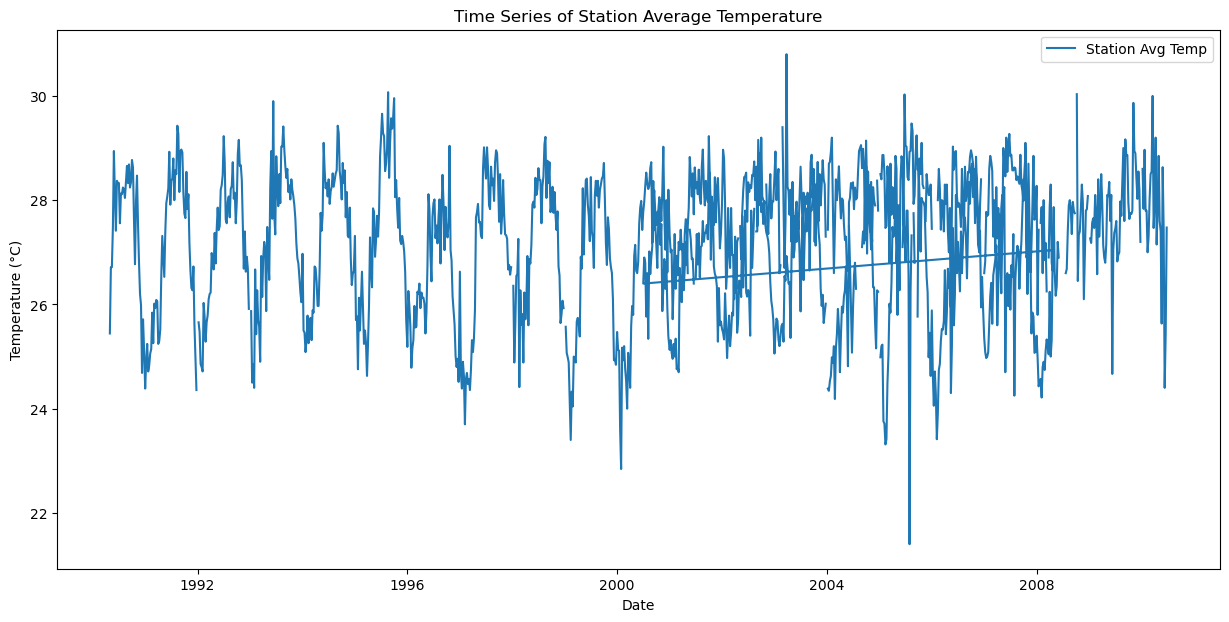

In [24]:
# c. Analyze patterns across time for average temperatures 
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
plt.figure(figsize=(15, 7))
plt.plot(df['week_start_date'], df['station_avg_temp_c'], label='Station Avg Temp')
plt.title('Time Series of Station Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## 4. Correlation matrix

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/1972142584.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


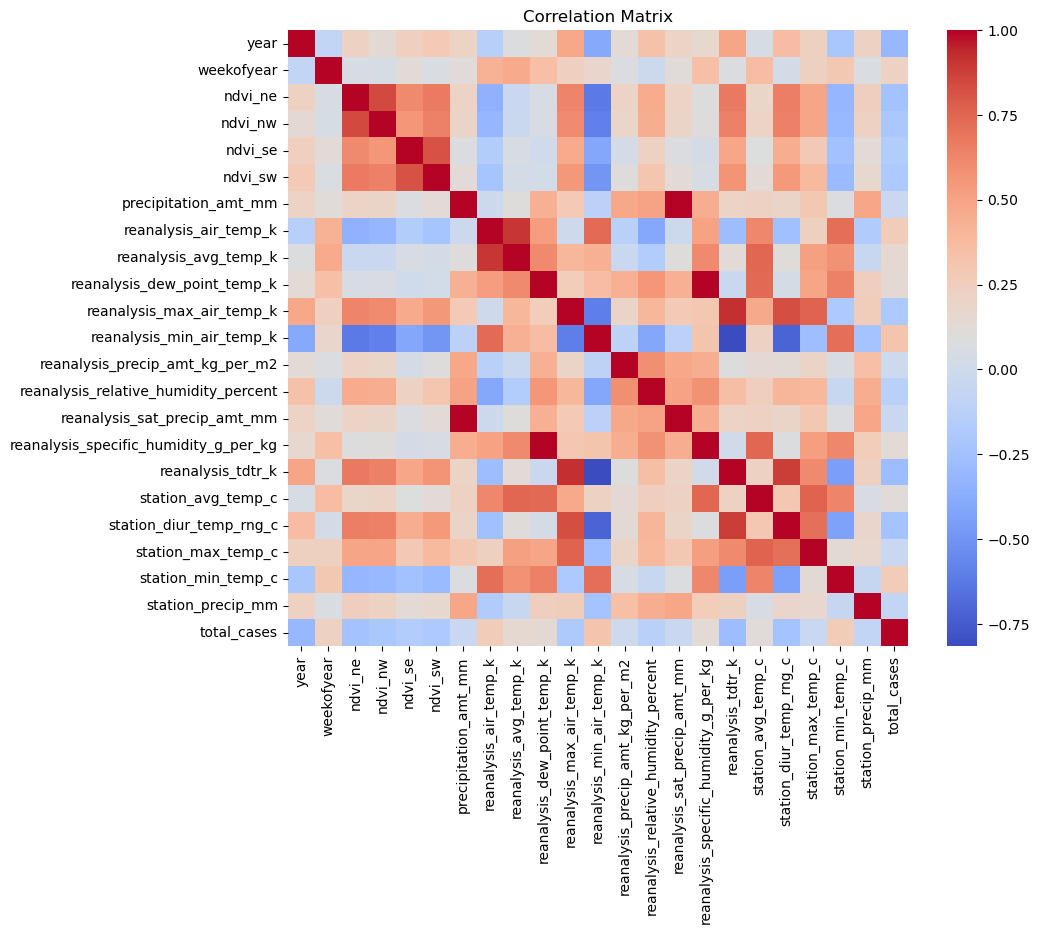

In [25]:
## 4. Correlation matrix
# Overall
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/1372841160.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = sj_data.corr()


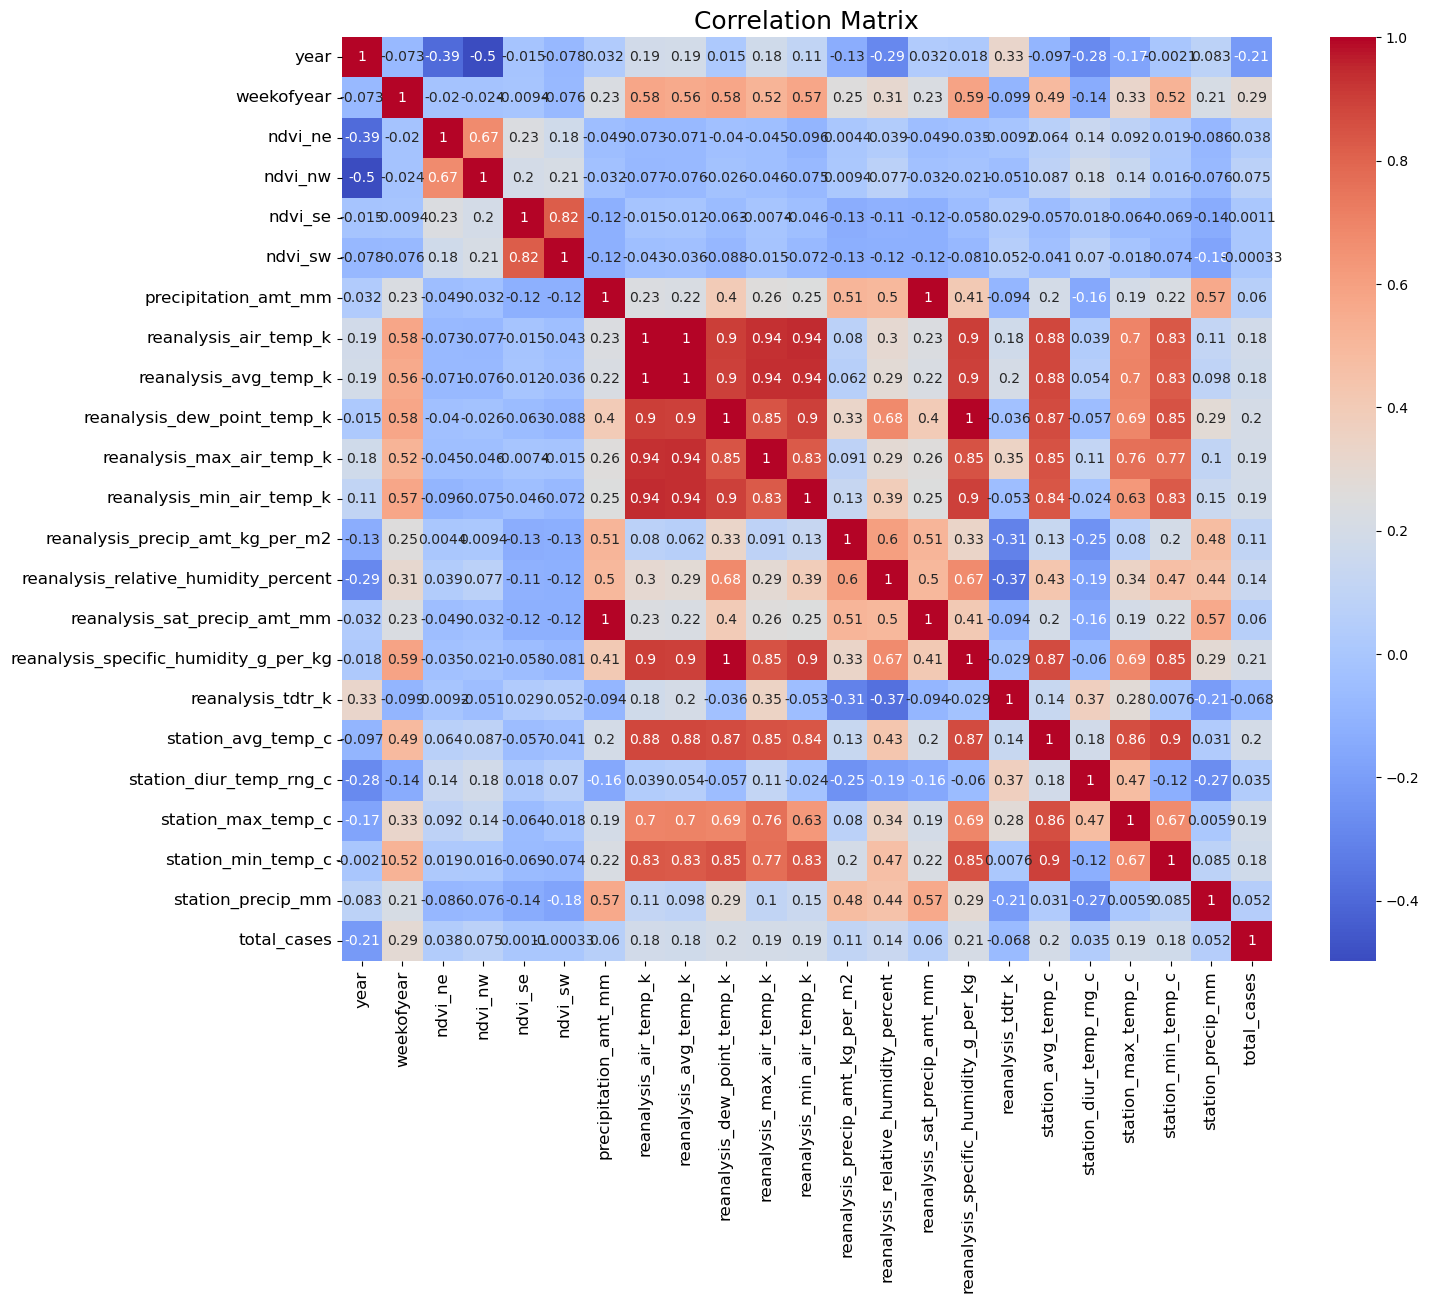

In [26]:
# For city sj
sj_data = df[df['city'] == 'sj']
correlation_matrix = sj_data.corr()
plt.figure(figsize=(15, 12))
cax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
cax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

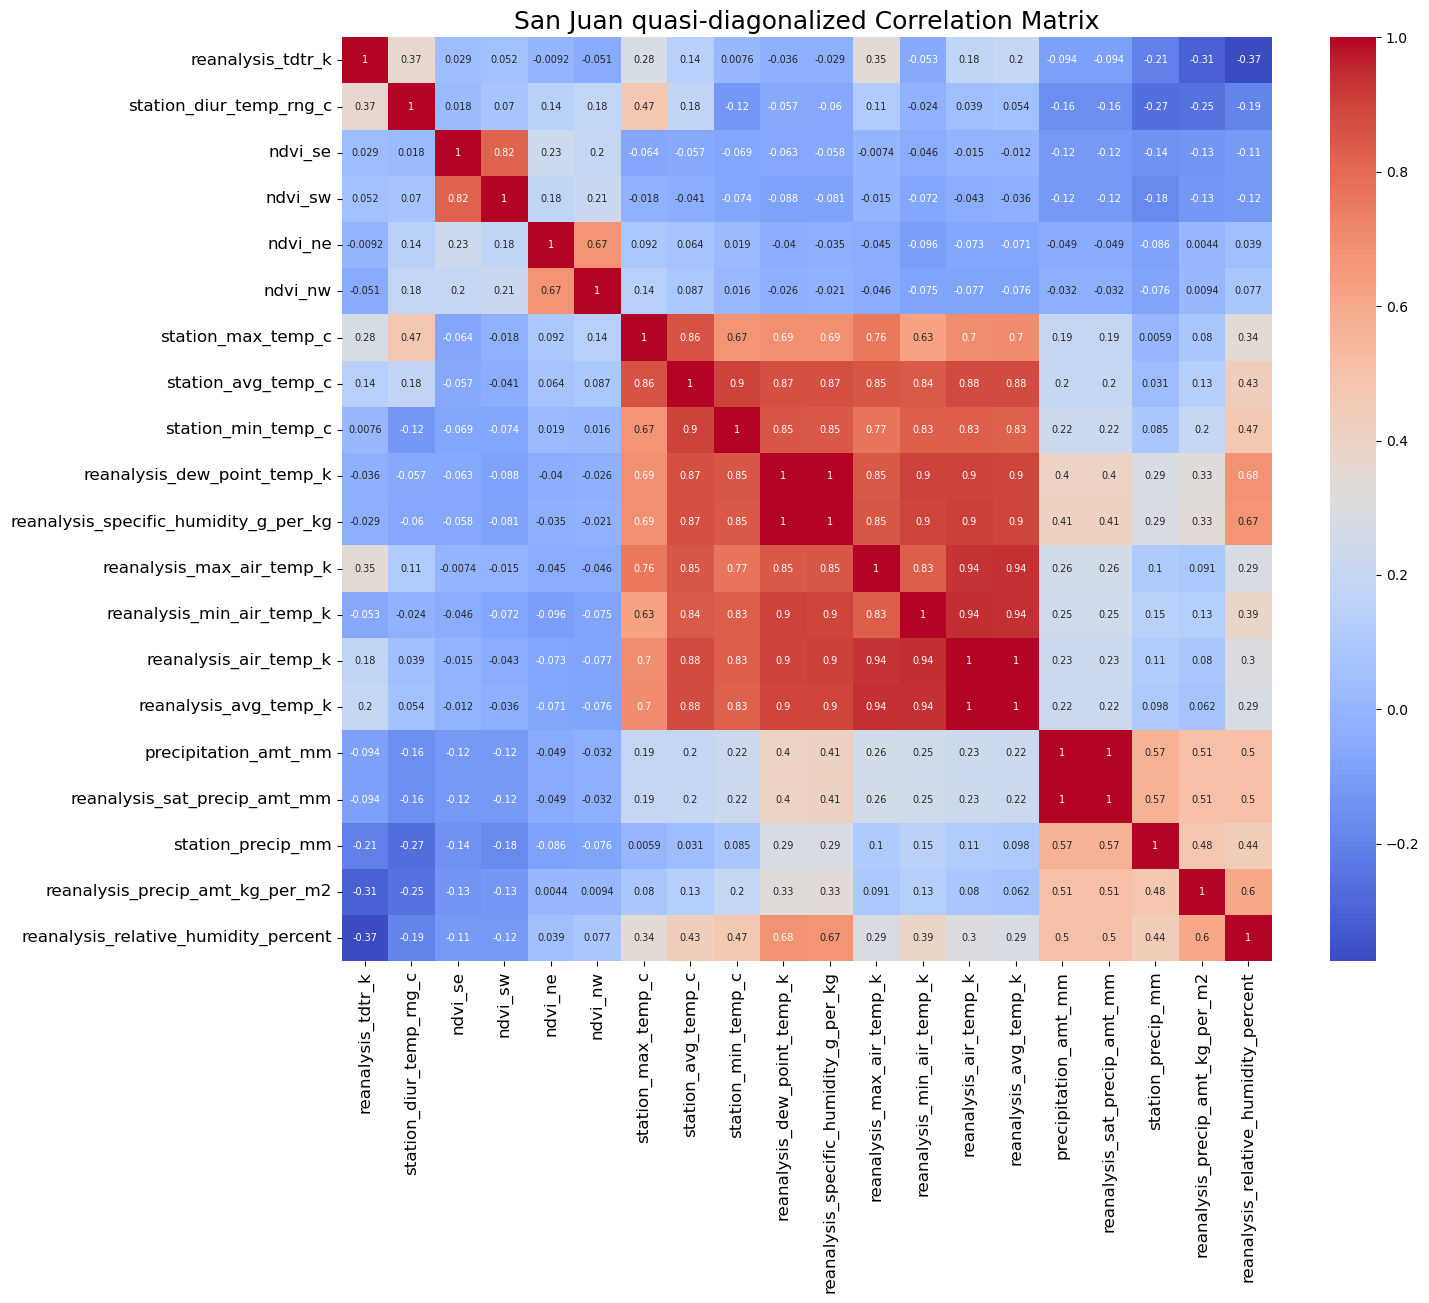

In [27]:
plt.figure(figsize=(15, 12))
cax = sns.heatmap(sj_quasi_diag, annot=True ,annot_kws={"size": 7}, cmap='coolwarm')
cax.tick_params(labelsize=12)
plt.title('San Juan quasi-diagonalized Correlation Matrix', fontsize=18)
plt.show()

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/458949595.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(sj_data.corr(), method="complete", cmap='coolwarm', annot=True,


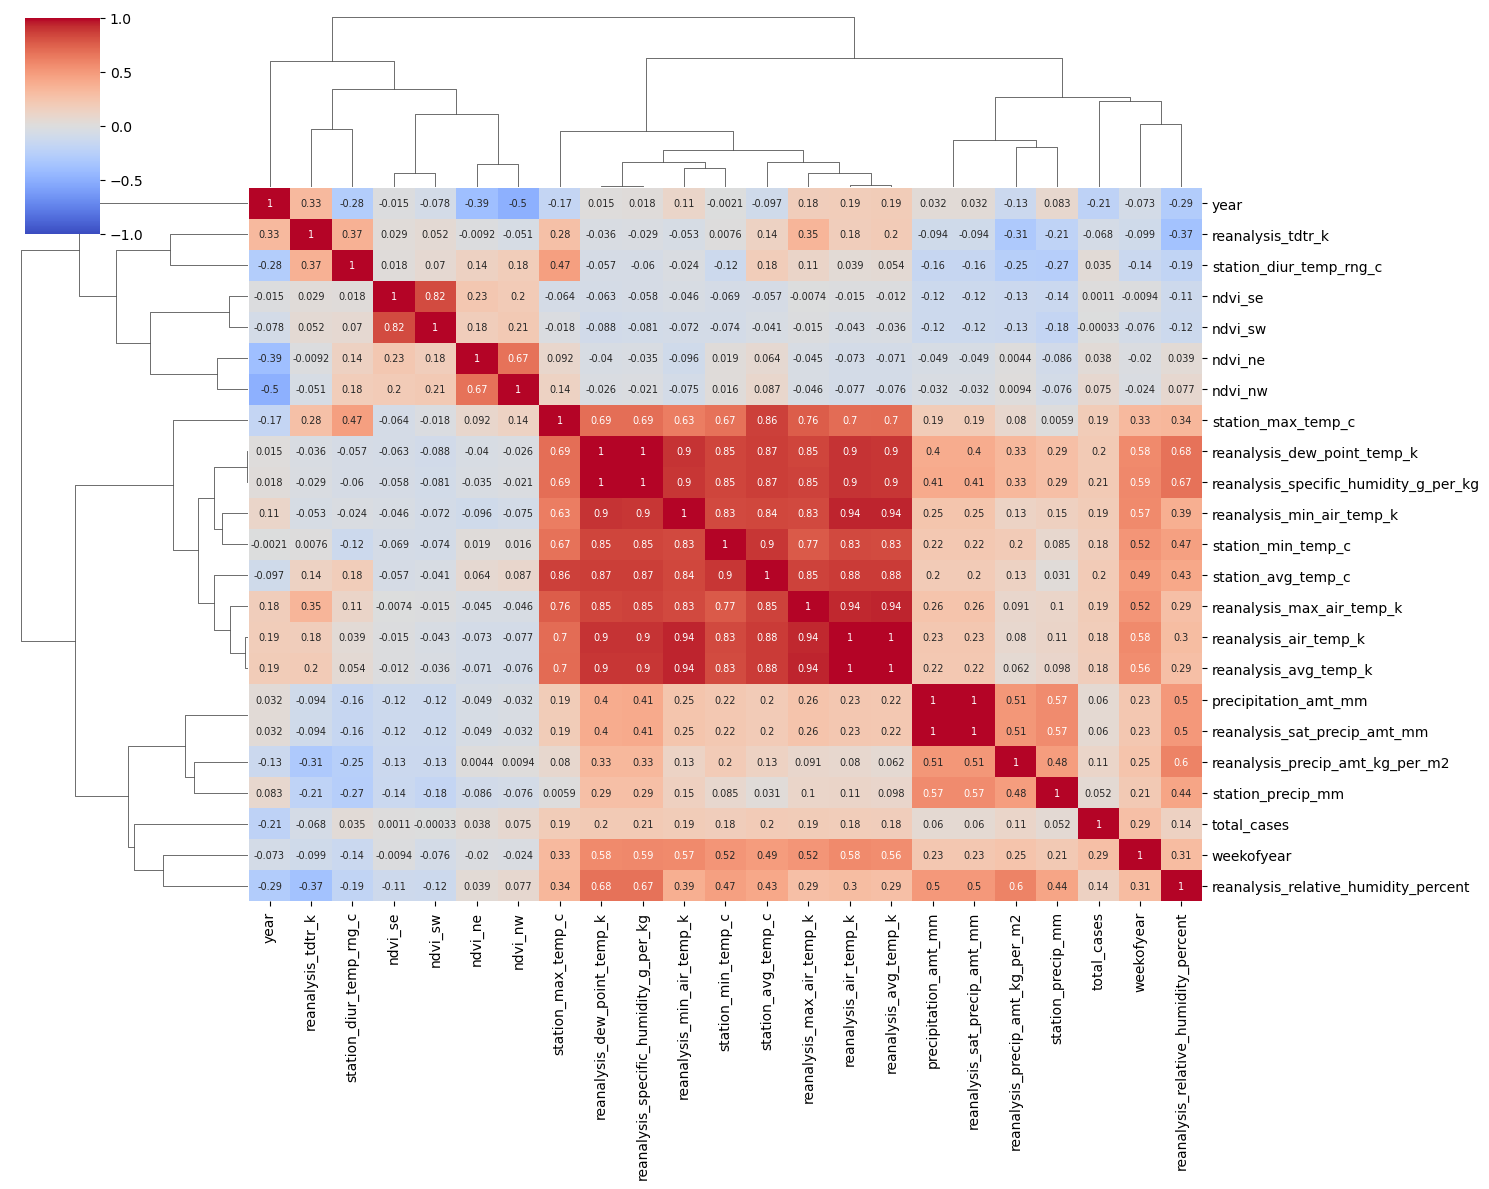

In [28]:
sns.clustermap(sj_data.corr(), method="complete", cmap='coolwarm', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/3432616972.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = iq_data.corr()


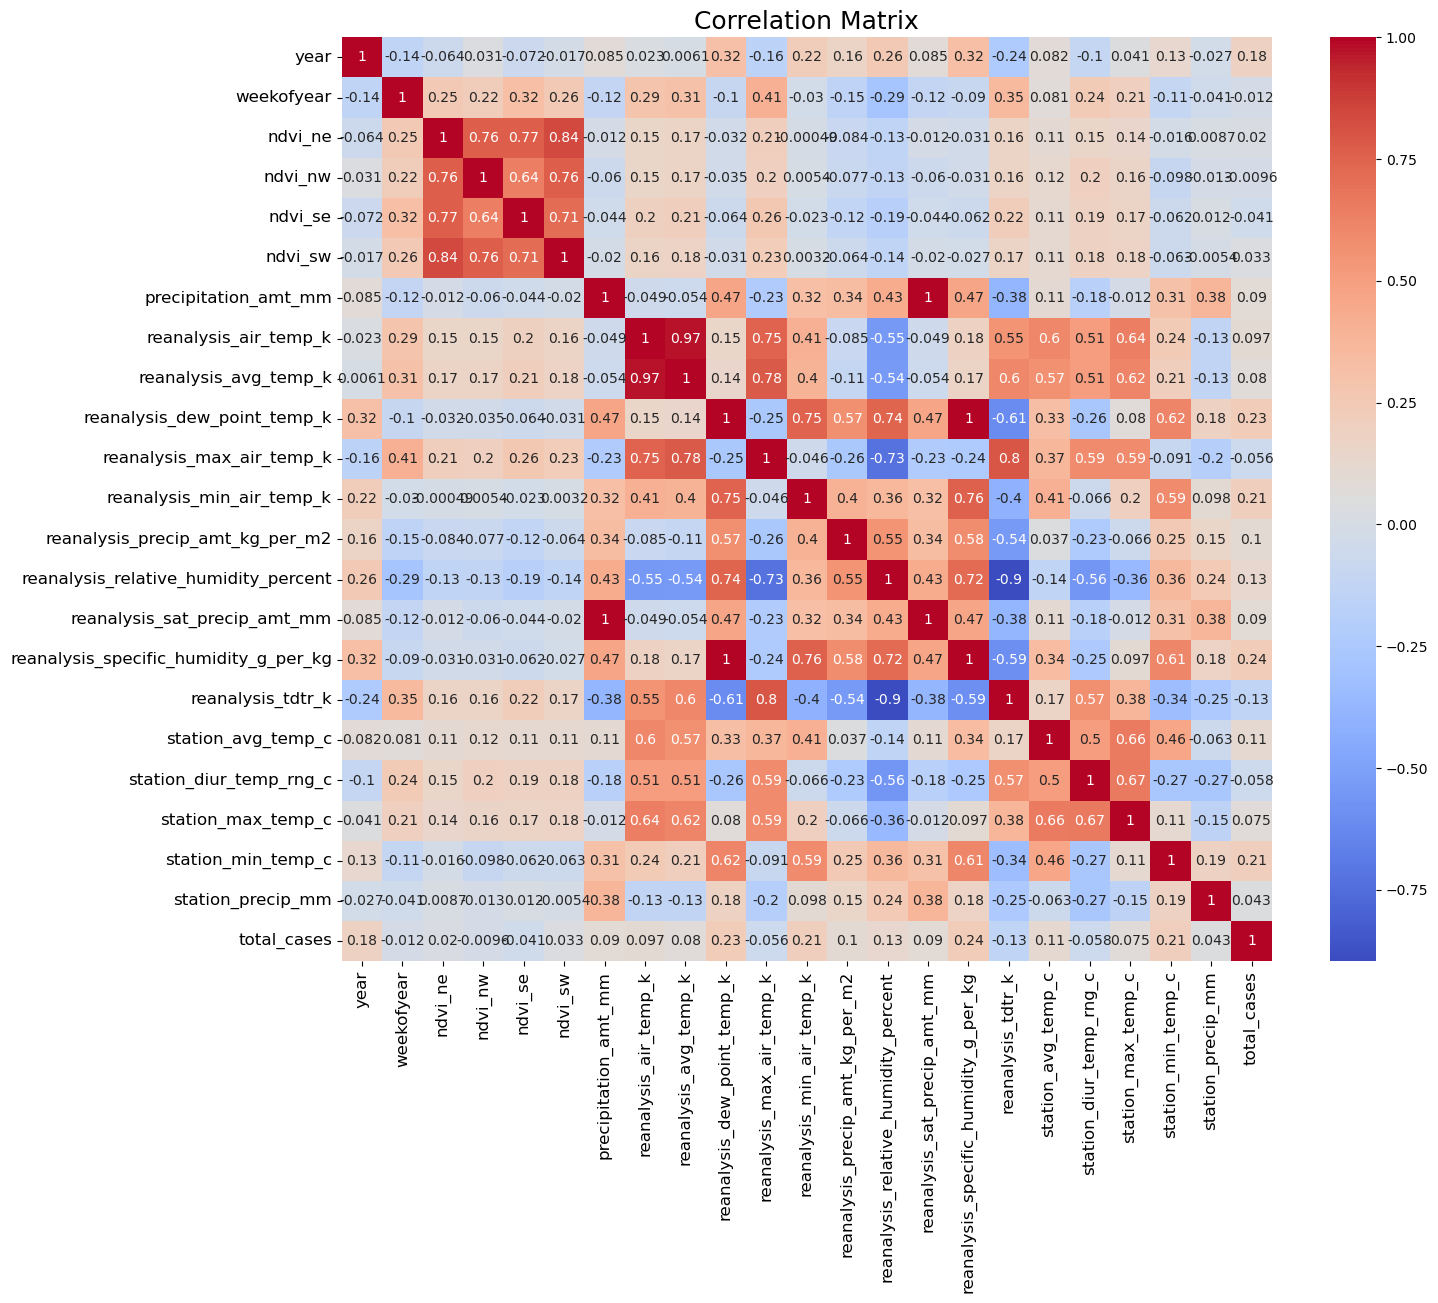

In [29]:
# For city iq
iq_data = df[df['city'] == 'iq']
correlation_matrix = iq_data.corr()
plt.figure(figsize=(15, 12))
cax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
cax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

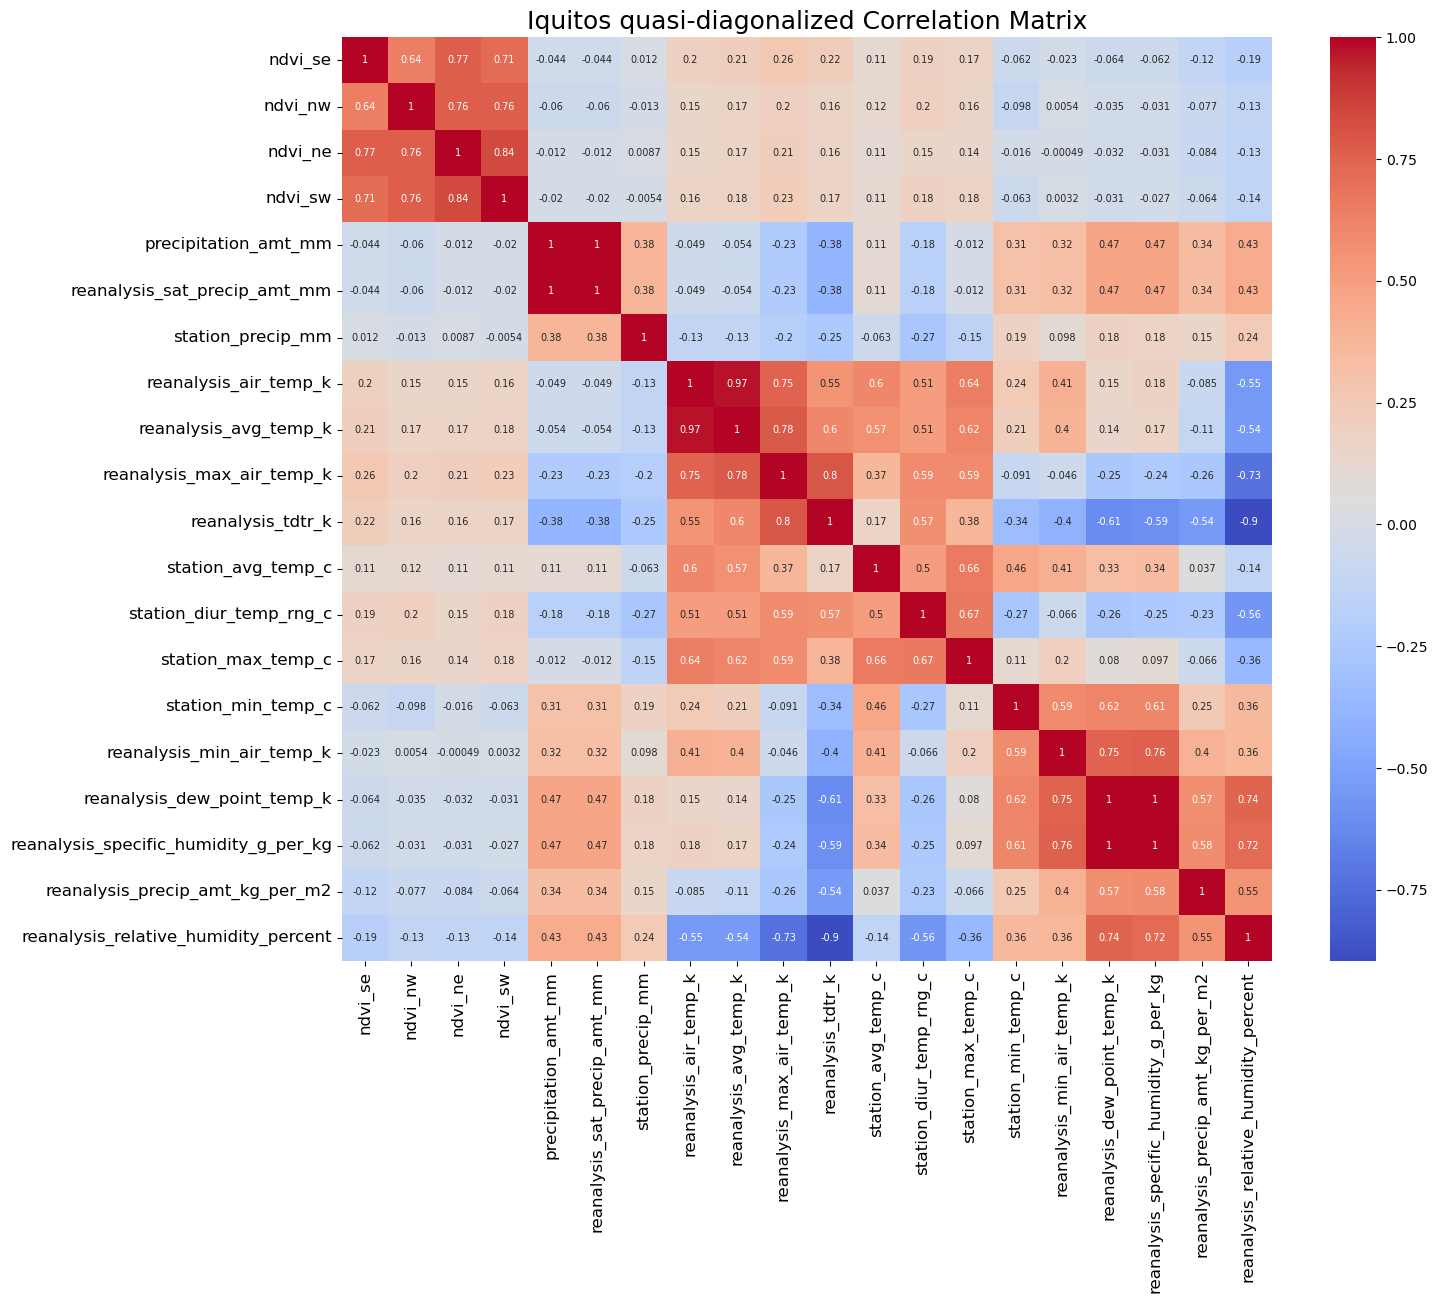

In [30]:
plt.figure(figsize=(15, 12))
cax = sns.heatmap(iq_quasi_diag, annot=True, annot_kws={"size": 7}, cmap='coolwarm')
cax.tick_params(labelsize=12)
plt.title('Iquitos quasi-diagonalized Correlation Matrix', fontsize=18)
plt.show()

/var/folders/sl/1mdv9dys2gs9j2lr3pw7f3sm0000gn/T/ipykernel_57156/3884280001.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(iq_data.corr(), method="complete", cmap='coolwarm', annot=True,


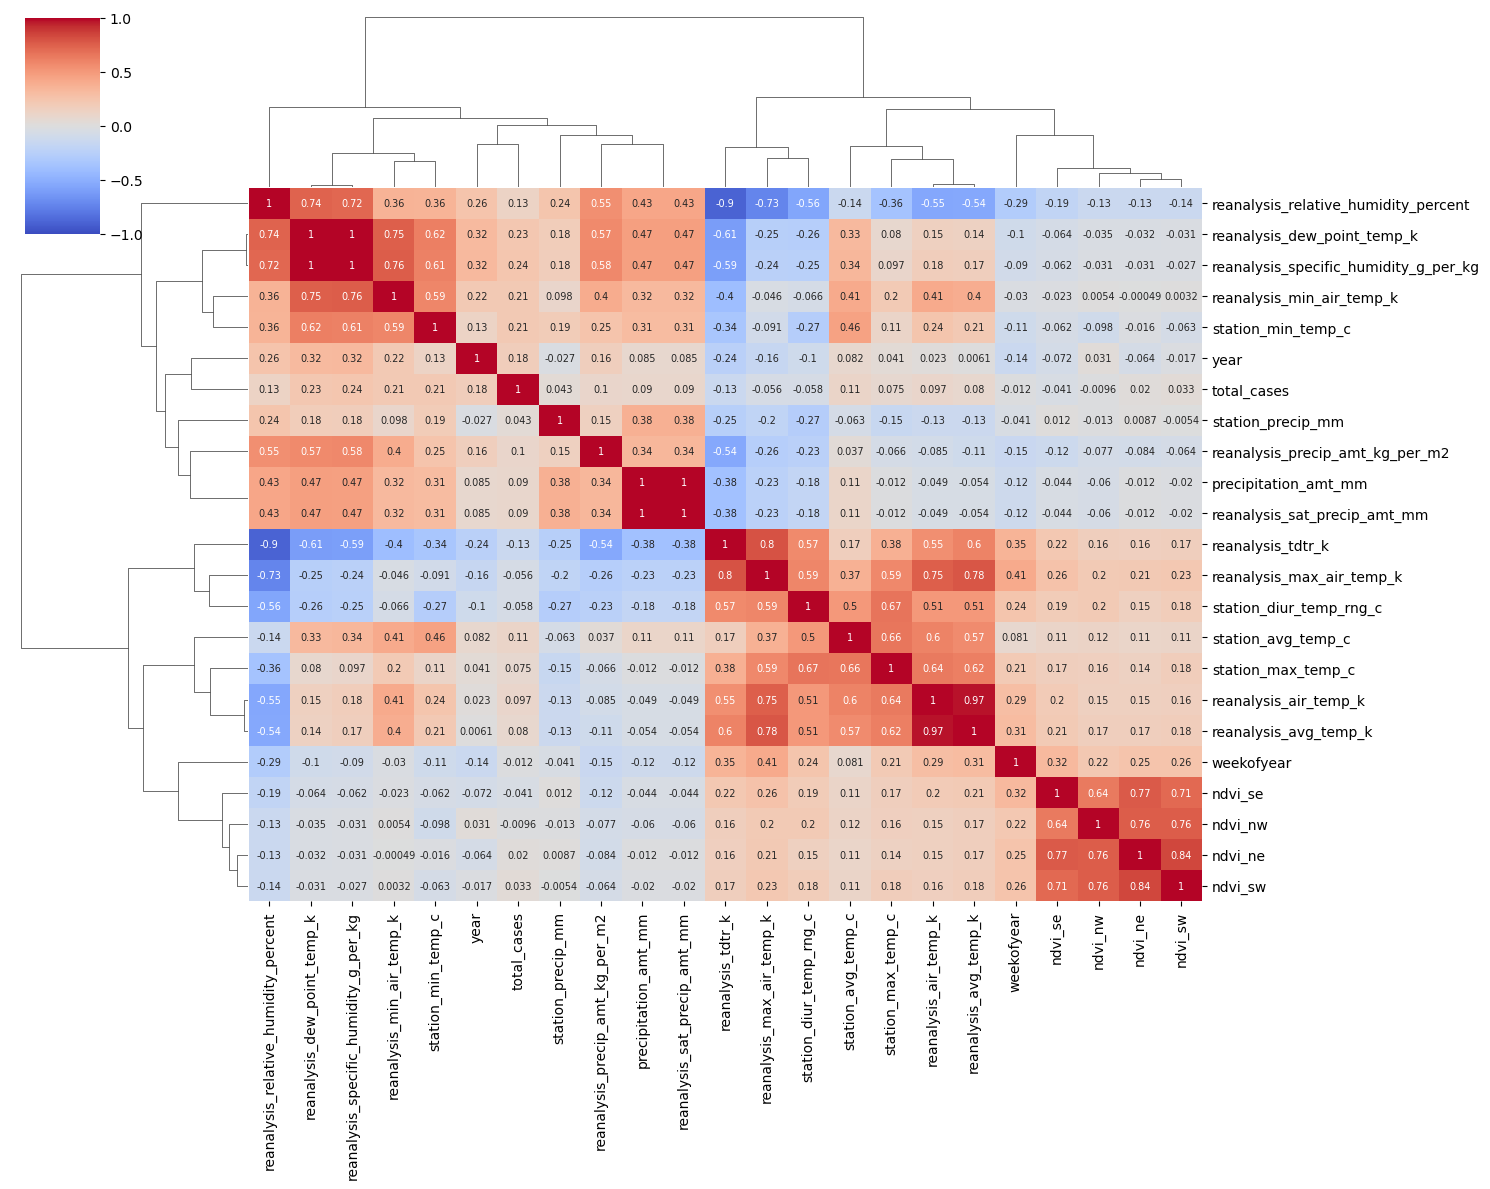

In [31]:
sns.clustermap(iq_data.corr(), method="complete", cmap='coolwarm', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))

 ## 5. Duplicates

In [32]:
 ## 5. Checking duplicates
df[df.duplicated()].shape

(0, 26)

## 6. Missing values

In [33]:
## 6. Checking missing values
print(df.isnull().sum())

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

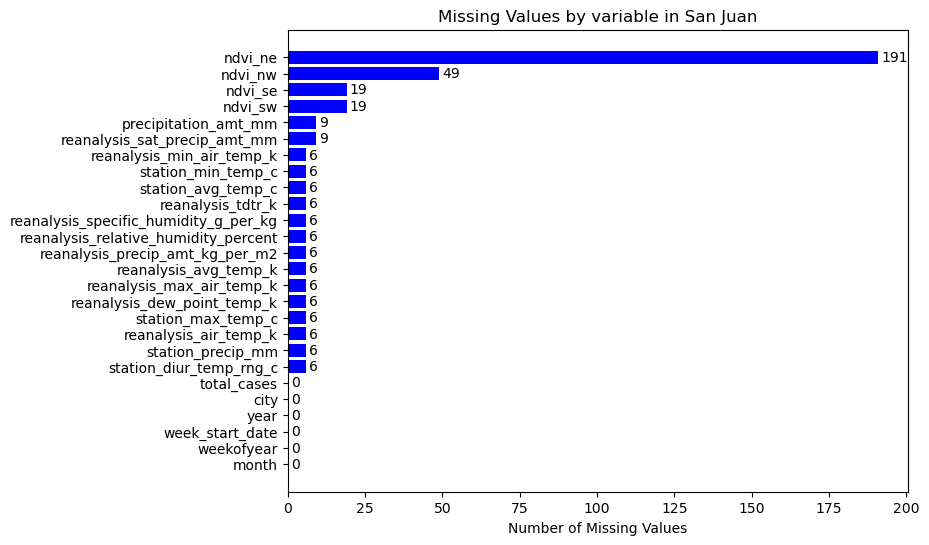

In [34]:
# “sj” city
sj_data = df[df['city'] == 'sj']
sj_data.isna().sum(0)
null_rank_sj = sj_data.isna().sum(0).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(null_rank_sj.index, null_rank_sj.values, color='blue')
plt.xlabel('Number of Missing Values')
plt.title('Missing Values by variable in San Juan')
plt.gca().invert_yaxis() 

for bar, value in zip(bars, null_rank_sj.values):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, str(value), va='center', color='black')

plt.show()

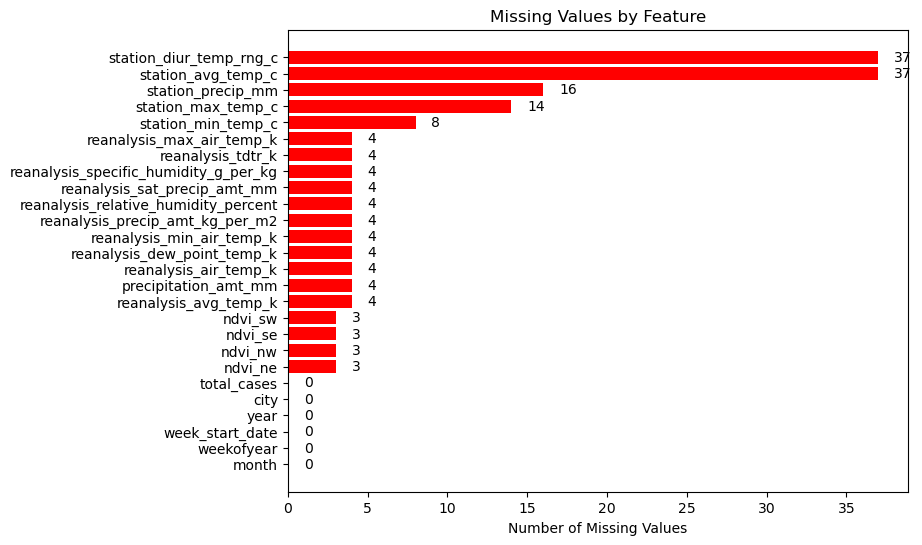

In [35]:
# “iq” city
iq_data = df[df['city'] == 'iq']
iq_data.isna().sum(0)
null_rank_iq = iq_data.isna().sum(0).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(null_rank_iq.index, null_rank_iq.values, color='red')
plt.xlabel('Number of Missing Values')
plt.title('Missing Values by Feature')
plt.gca().invert_yaxis() 

for bar, value in zip(bars, null_rank_iq.values):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, str(value), va='center', color='black')

plt.show()

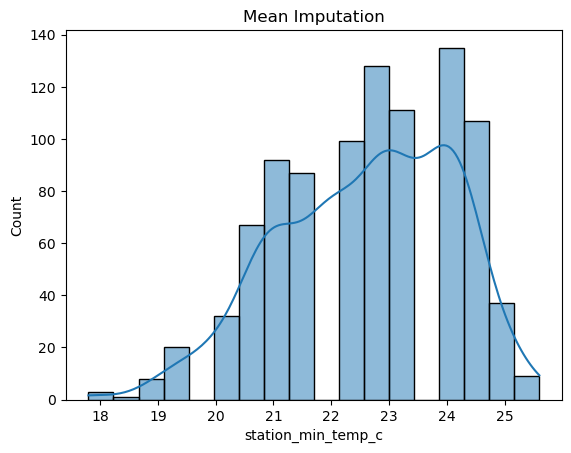

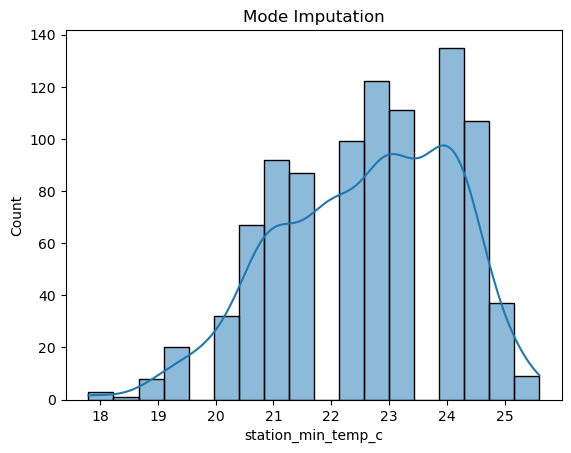

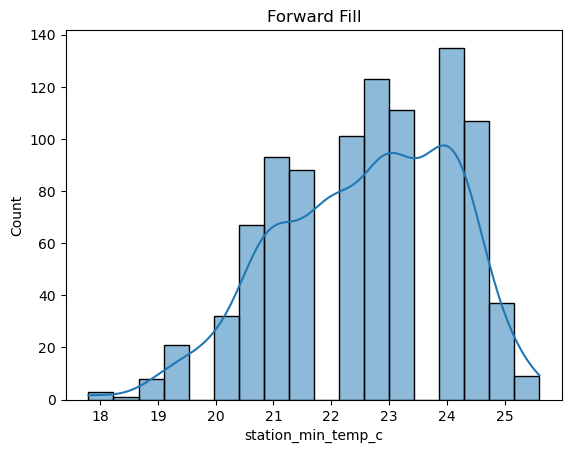

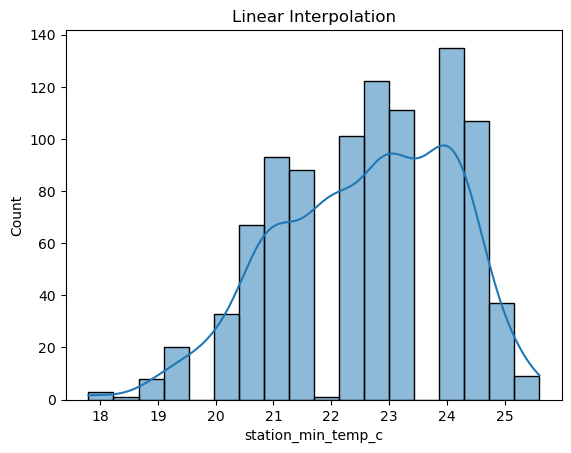

In [60]:
# Fill missing value with different methods for "station_min_temp_c"

# Feature to focus on
feature = 'station_min_temp_c'

df_sj = df[df['city'] == 'sj']

# Calculate imputation values
mean_value = df_sj[feature].mean()
mode_value = df_sj[feature].mode()
df_ffill = df_sj[feature].fillna(method='ffill')
df_linear_interp = df_sj[feature].interpolate(method='linear')

# Fill missing values with imputation values
df_mean = df_sj[feature].fillna(mean_value)
df_mode = df_sj[feature].fillna(mode_value)

# Mean imputation histogram
sns.histplot(df_mean, kde=True)
plt.title('Mean Imputation')
plt.show()

# Mode imputation histogram
sns.histplot(df_mode, kde=True)
plt.title('Mode Imputation')
plt.show()

# Forward fill histogram
sns.histplot(df_ffill, kde=True)
plt.title('Forward Fill')
plt.show()

# Linear interpolation histogram
sns.histplot(df_linear_interp, kde=True)
plt.title('Linear Interpolation')
plt.show()